# **Multiple Models ML + ResNet Latent Patch Threshold Synthetic Cross Validation**

## *1. Dataset Loading and Preprocessing*

### **1.1. Importing Required Libraries**

- Pathlib, os, shutil: These are used for handling file paths and directory manipulations. shutil is helpful in copying or moving files.
- NumPy: Essential for handling large arrays and numerical operations.
- Matplotlib, Seaborn: For data visualization. matplotlib.pyplot helps create various plots, and seaborn offers more advanced visualizations, typically with a higher-level API.
- Pandas: For data manipulation, especially working with tabular data. pandas.DataFrame is extensively used for loading, modifying, and analyzing datasets.
- Pickle: For serializing Python objects, commonly used to save/load objects such as models and dataframes.
- PIL (Python Imaging Library): For handling image data, including reading, processing, and transforming images.
- TQDM: For displaying progress bars when running loops, typically useful for large datasets or long-running operations.
- PyTorch & torchvision: Essential libraries for building and training deep learning models. torch.utils.data.DataLoader is for batching and loading datasets, torchvision.datasets provides utilities for image datasets, and torch.optim contains optimization algorithms.
- scikit-learn: Specifically, StandardScaler for feature scaling, and BaseEstimator for defining custom models.

These libraries will help in the preprocessing, model training, evaluation, and visualization steps throughout the project.

#### Key Notes:

 - Using pathlib for path handling improves cross-platform compatibility.

- Torch and Torchvision are used to load image datasets and prepare for deep learning tasks.

- Using Pickle enables storing large DataFrames efficiently for future use.

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

import pickle

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **1.2. Download and extract the data**

#### **Dataset Directory and Checkpoints Setup**

- Setting up dataset paths dynamically using os.path.abspath("__file__") to locate the dataset.

- Normalizing paths for compatibility across Windows and Linux.

- Checkpoint directory creation ensures data persistence for large datasets.



1. **Define the Dataset Directory**:
   - The `dataset_dir` variable is constructed using `os.path.join()` to specify the path where the dataset is stored. The dataset directory is located relative to the current working directory, and we use `os.path.normpath()` to ensure the path format is correct for the system.

2. **Specify the File Path**:
   - The variable `file_path` is used to specify the full path to the `mvtec_meta_features_dataset.csv` file within the dataset directory.

3. **Avoiding MemoryError**:
   - The file is expected to be loaded in chunks, which is important for managing large datasets that might not fit entirely into memory at once. This chunking approach will help avoid potential `MemoryError` issues when processing large files.


#### Key Notes:

- Using os.makedirs(..., exist_ok=True) prevents errors if the directory already exists.

- Relative path handling makes the script more portable across environments.

- Checkpoints help reduce load time by storing preprocessed data.

In [2]:
# Load the dataset in chunks to avoid MemoryError
dataset_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "..\..\..\Dataset")
dataset_dir = os.path.normpath(dataset_dir)
file_path = os.path.join(dataset_dir, 'mvtec_meta_features_dataset.csv')


### **1.3. Loading Dataset with Chunk Processing**

#### Explanation:

- Checks if a preprocessed dataset exists to load faster.

- Uses chunk processing (chunksize=1000) to prevent MemoryErrors on large CSV files.

- Saves the final DataFrame to a pickle file for efficiency.

#### Key Notes:

- Chunk processing is essential for handling large datasets in memory-constrained environments.

- Pickle is faster than CSV for loading structured data.

- Using ignore_index=True ensures the DataFrame is properly indexed after concatenation.


### **1.4. Display Dataset Preview**

This prints a preview of the dataset to ensure it loaded correctly.

#### Loading and Saving Data with Checkpoints

In this section, we implement checkpointing to efficiently load and save data, preventing data loss and avoiding unnecessary recomputation:

1. **Define the Checkpoint Path**:
   - The `checkpoint_dir` variable is created to specify the directory where the checkpoint file will be stored. If the directory does not exist, it will be created using `os.makedirs()`. 
   - The checkpoint file `features_df_checkpoint.pkl` will be saved in this directory.

2. **Check if the Checkpoint File Exists**:
   - Before loading the data from the original CSV file, we first check if the checkpoint file already exists. If it does, we load the DataFrame from this file using `pickle.load()`.

3. **Load the Dataset in Chunks (if Checkpoint Doesn't Exist)**:
   - If the checkpoint file does not exist, we load the dataset in chunks using `pd.read_csv()` with the `chunksize` parameter. This helps manage memory usage when working with large datasets. The chunks are appended to a list and then concatenated into a single DataFrame.
   
4. **Save the DataFrame to a Checkpoint File**:
   - After loading the data, the resulting DataFrame is saved to a checkpoint file using `pickle.dump()` to prevent the need to reload the dataset in the future.

5. **Display the First Few Rows**:
   - Finally, we display the first few rows of the loaded DataFrame to verify that the data has been successfully loaded and processed.

In [3]:
# Define the checkpoint path
checkpoint_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'Checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'features_df_checkpoint.pkl')

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
	# Load the DataFrame from the checkpoint file
	with open(checkpoint_path, 'rb') as f:
		features_df = pickle.load(f)
else:
	# Load the dataset in chunks to avoid MemoryError
	chunk_size = 1000  # Adjust the chunk size based on your memory capacity
	chunks = []
	for chunk in pd.read_csv(file_path, chunksize=chunk_size):
		chunks.append(chunk)
	features_df = pd.concat(chunks, ignore_index=True)

	# Save the DataFrame to a checkpoint file
	with open(checkpoint_path, 'wb') as f:
		pickle.dump(features_df, f)

# Display the first few rows of the DataFrame
features_df.head()

,category,subclass,set_type,anomaly_status,anomaly_type,width,height,aspect_ratio,num_pixels_b,num_pixels_g,...,pixel_150519,pixel_150520,pixel_150521,pixel_150522,pixel_150523,pixel_150524,pixel_150525,pixel_150526,pixel_150527,pixel_150528
0,bottle,Consumer Products,train,normal,none,900,900,1.0,6999311,6773371,...,255,255,255,255,255,255,255,255,255,255
1,bottle,Consumer Products,train,normal,none,900,900,1.0,7067411,6860049,...,255,255,255,255,255,255,255,255,255,255
2,bottle,Consumer Products,train,normal,none,900,900,1.0,6960857,6767973,...,255,255,255,255,255,255,255,255,255,255
3,bottle,Consumer Products,train,normal,none,900,900,1.0,6941894,6749162,...,255,255,255,255,255,255,255,255,255,255
4,bottle,Consumer Products,train,normal,none,900,900,1.0,7080991,6879424,...,255,255,255,255,255,255,255,255,255,255


- Dataset Example: The table shows meta-data for a few images. Each row represents an image, and columns represent various image features like:

- Category: The object category the image belongs to.
- Anomaly Status: Whether the image is normal or contains an anomaly.
- Pixel Data: Columns like num_pixels_b, num_pixels_g, and num_pixels_r represent the pixel counts of each color channel. These features can be used for distinguishing different object types or identifying anomalies.

### **1.5. Category Extraction and Range Definition**

In this section, we extract and define the categories from the dataset for further processing:

#### **Create a List of Categories**:
   - We use `features_df['category'].unique()` to extract the unique categories present in the dataset. The result is then sorted using `np.sort()` to ensure that the categories are ordered.

#### **Define the Range for Categories**:
   - `min_categories` and `max_categories` are defined to limit the number of categories to be considered. In this case, we set the range to process categories from index 0 to index 15.
   
This prepares the categories for analysis or model training and defines the subset of categories that will be used for further operations.

In [4]:
# create a list of the categories
categories = np.sort(features_df['category'].unique())
min_categories = 0
max_categories = 15


### **1.6. Loading Image Paths for Each Category**

In this section, we define a function to load image paths and ground truth paths for each category in the dataset. This process ensures that we can efficiently access the image and ground truth data during model training and evaluation.

#### **Define the `load_image_paths_from_category` Function**:
   - This function takes a category name as input and constructs paths for `train`, `test`, `validation`, and `ground_truth` directories within that category.
   - The function also defines two helper functions:
     - `get_image_paths(root_path)`: Recursively searches through directories for image files with specified extensions (`.png`, `.jpg`, `.jpeg`, `.bmp`, `.gif`).
     - `get_ground_truth_paths(root_path)`: Similar to `get_image_paths`, but specifically looks for ground truth image files in the `ground_truth` folder.

#### **Initialize Dictionaries to Store Image Paths**:
   - We create dictionaries (`train_image_paths_dict`, `test_image_paths_dict`, `validation_image_paths_dict`, `gt_image_paths_dict`) to store image paths for each category.
   - The function is called for each category, and paths are stored in these dictionaries for easy access later.

This ensures that all image and ground truth paths for each category are correctly loaded and organized.

In [5]:
# Function to get all image and ground_truth paths for all categories
def load_image_paths_from_category(category):
    train_path = os.path.join(dataset_dir, category, 'train')
    test_path = os.path.join(dataset_dir, category, 'test')
    validation_path = os.path.join(dataset_dir, category, 'validation')
    gt_path = os.path.join(dataset_dir, category, 'ground_truth')
    
    def get_image_paths(root_path):
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        image_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(image_extensions):
                    image_paths.append(os.path.join(dirpath, filename))
        return image_paths
    
    def get_ground_truth_paths(root_path):
        ground_truth_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        ground_truth_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(ground_truth_extensions):
                    ground_truth_paths.append(os.path.join(dirpath, filename))
        return ground_truth_paths
    
    # Get image and ground_truth paths
    train_image_paths = get_image_paths(train_path)
    test_image_paths = get_image_paths(test_path)
    validation_image_paths_dict = get_image_paths(validation_path)
    gt_image_paths = get_ground_truth_paths(gt_path)
   
    return train_image_paths, test_image_paths, validation_image_paths_dict, gt_image_paths

# Initialize dictionaries to store images
train_image_paths_dict = {}
test_image_paths_dict = {}
validation_image_paths_dict = {}
gt_image_paths_dict = {}

for category in categories:
    train_image_paths, test_image_paths, validation_path, gt_image_paths = load_image_paths_from_category(category)
    train_image_paths_dict[category] = train_image_paths
    test_image_paths_dict[category] = test_image_paths
    validation_image_paths_dict[category] = validation_path
    gt_image_paths_dict[category] = gt_image_paths


### **1.7. Image Transformation Pipeline**

In this section, we define the image transformation pipeline that will be applied to the images before feeding them into the model. This ensures that all images are processed consistently.

#### **Define the Transformation Pipeline**:
   - The `transforms.Compose` method is used to chain multiple image transformations together.
   - The transformations include:
     - `transforms.Resize((224, 224))`: Resizes each image to a fixed size of 224x224 pixels, which is a standard input size for many pre-trained models like ResNet50.
     - `transforms.ToTensor()`: Converts the image into a PyTorch tensor and scales the pixel values by dividing them by 255, so they are in the range [0, 1].

This transformation ensures that the images are resized to the correct dimensions and are in a format suitable for model training and inference.








In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformation pipeline using torchvision.transforms.Compose
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor and divide by 255.0
])


### **1.8. Loading and Transforming Training Images**

In this section, we load the training datasets for each category using the `ImageFolder` class from PyTorch's `torchvision.datasets` module. Here's a breakdown of the steps:

#### **Define the Path to Training Images**:
   - We use `os.path.join()` to create the path to the training images for each category stored in the dataset directory.

#### **Using the `ImageFolder` Dataset Class**:
   - `ImageFolder` is a built-in dataset class in PyTorch that helps in loading image datasets from directories. The images are expected to be organized in subdirectories where each subdirectory corresponds to a class (category) in the dataset.
   - It automatically loads the images and labels based on the folder structure. In this case, the folder name corresponds to the category label.

#### **Applying Image Transformations**:
   - The `transform` (which was defined in the previous section) is applied to each image during the dataset loading. This ensures that every image is resized to 224x224 pixels and converted into a PyTorch tensor before being passed to the model.

#### **Store the Datasets**:
   - We create an empty dictionary called `good_datasets_dict` to store the datasets for each category.
   - We iterate over each category, load the dataset, and store it in the dictionary with the category name as the key.

The result is that each category's training dataset is now loaded and preprocessed, ready for use in training a machine learning model.

In [7]:
# Define the path to the training images
# Load the train dataset using the ImageFolder dataset class
# ImageFolder is a PyTorch dataset class for loading images from a directory
# It automatically loads images from subdirectories and applies transformations to them
# In this case, 'transform' is a transformation applied to each image in the dataset
# It preprocesses the images before they are used for training
# Initialize an empty dictionary to store datasets for all categories
good_datasets_dict = {}

# Iterate through each category and load the dataset
for category in categories:
    train_image_path = os.path.join(dataset_dir, category, 'train')
    dataset = ImageFolder(root=train_image_path, transform=transform)
    good_datasets_dict[category] = dataset

## *2. Loading a Pretrained ResNet Model*

### **ResNet Feature Extractor Class**

This section defines a custom class `resnet_feature_extractor`, which is designed to extract feature maps from a pretrained ResNet-50 model. Here's a detailed explanation of its components:

#### **Class Definition**:
   - The class `resnet_feature_extractor` inherits from `torch.nn.Module` to ensure it can be used as part of a PyTorch neural network model.

#### **Model Initialization (`__init__` Method)**:
   - **Pretrained ResNet-50**: The model is initialized with a pretrained ResNet-50 model using weights from ImageNet, loaded via `resnet50(weights=ResNet50_Weights.DEFAULT)`.
   - **Set to Evaluation Mode**: The model is switched to evaluation mode (`self.model.eval()`) to disable dropout and batch normalization updates during inference.
   - **Freeze Parameters**: To prevent the ResNet model from being updated during training, all parameters in the model are frozen by setting `param.requires_grad = False`.

#### **Hook Functions**:
   - **Purpose**: A hook is defined to extract feature maps from the model during the forward pass.
   - **Hook Registration**: The hook is registered on the last block of `layer2` and `layer3` to extract feature maps from these layers.
   - **Saving the Output**: The hook saves the output feature map of the respective layers into the `self.features` list.

#### **Forward Method**:
   - **Input Handling**: The forward method processes the input through the ResNet model using `torch.no_grad()` to disable gradient computation, ensuring the feature maps are extracted without updating the model.
   - **Average Pooling**: A 2D average pooling layer is defined to process the feature maps, which helps reduce the spatial dimensions of the feature maps.
   - **Adaptive Pooling**: An adaptive average pooling layer is used to resize the feature maps to the same spatial size for concatenation.
   - **Concatenating Feature Maps**: The resized feature maps from `layer2` and `layer3` are concatenated along the channel dimension, creating a combined feature representation of the input image.
   - **Flattening**: The concatenated feature map is reshaped to create a column vector (`patch`) that represents the extracted features.

This custom extractor enables the efficient extraction of high-level features from a pretrained ResNet-50 model, which can then be used for various downstream tasks such as classification, anomaly detection, or feature analysis.








In [8]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained ResNet model."""
        super(resnet_feature_extractor, self).__init__()

        # Load a pretrained ResNet-50 model with default ImageNet weights
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
        self.model.eval()

        # Freeze all parameters in the ResNet model to prevent them from being updated
        for param in self.model.parameters():
            param.requires_grad = False

        # Hook function to extract feature maps during the forward pass
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map in self.features."""
            self.features.append(output)

        # Register the hook on the last block of layer2 to extract its output
        self.model.layer2[-1].register_forward_hook(hook)

        # Register the hook on the last block of layer3 to extract its output
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):
        """Forward method to process the input and extract concatenated feature maps."""
        
        # Initialize the features list to store outputs from the hooks
        self.features = []

        # Perform a forward pass through the ResNet model without computing gradients
        with torch.no_grad():
            _ = self.model(input)

        # Define a 2D average pooling layer with kernel size 3 and stride 1
        self.avg = torch.nn.AvgPool2d(3, stride=1)

        # Get the spatial size (height, width) of the feature map from layer2
        fmap_size = self.features[0].shape[-2]  # Assume all feature maps have the same size

        # Define an adaptive average pooling layer to resize feature maps to the same size
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        # Resize and process the feature maps from layer2 and layer3
        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]

        # Concatenate the processed feature maps along the channel dimension
        patch = torch.cat(resized_maps, 1)   # merge the resized feature maps along the channel dimension
        patch = patch.reshape(patch.shape[1], -1).T #create a column tensor

        # Return the concatenated feature maps as the final output
        return patch


## *3. Extracting Features from Test Images Using ResNet*

In this section, we initialize the `resnet_feature_extractor` and use it to extract features from the first test image in each category. Here's a breakdown of the steps involved:

#### **Initialize Feature Extractor**:
   - The `resnet_feature_extractor` class, which was defined in the previous section, is instantiated as `backbone`. This class will be used to extract feature maps from a pretrained ResNet-50 model.

#### **Process Images for Feature Extraction**:
   - **Iterate Through Categories**: We loop through a subset of categories, from `min_categories` to `max_categories`, which are defined earlier in the code.
   - **Load the First Test Image**: For each category, we load the first test image using `PIL` (Python Imaging Library) from the respective category's test dataset path.
   - **Convert to RGB**: If the image is in grayscale (i.e., not in 'RGB' mode), it is converted to RGB by repeating the single grayscale channel three times.
   - **Apply Transformation**: The image is then passed through the predefined transformation pipeline (`transform`), which resizes the image and converts it to a PyTorch tensor. The `unsqueeze(0)` function adds a batch dimension to the tensor, making it compatible with the ResNet model input.

#### **Feature Extraction**:
   - The image tensor is passed through the `backbone` (the ResNet feature extractor) to extract the feature maps from the layers defined in the class.
   - The `feature` tensor contains the concatenated feature map from the two layers (`layer2` and `layer3`) of the ResNet model.

#### **Print the Shapes of the Extracted Feature Maps**:
   - After extracting the features, we print the shapes of the feature maps extracted from `layer2` and `layer3`, as well as the shape of the concatenated feature map. This helps verify the structure and dimensions of the extracted features, ensuring they are consistent with the model's output.

The feature extraction process allows us to obtain high-level representations of the images, which can be used for further analysis, anomaly detection, or model training.








In [10]:
# Initialize the resnet_feature_extractor
backbone = resnet_feature_extractor()

# Iterate through each category and process the first test image
for category in categories[min_categories:max_categories]:
    # Get the first test image from the current category using PIL
    image = Image.open(test_image_paths_dict[category][0])
    
    # Convert grayscale image to RGB by repeating the single channel three times
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Apply the transformation and add a batch dimension
    image = transform(image).unsqueeze(0)
    
    # Extract features using the backbone
    feature = backbone(image)
    
    # Print the shapes of the extracted feature maps
    print(f"Category: {category}")
    print(f"Feature map from layer2: {backbone.features[0].shape}")
    print(f"Feature map from layer3: {backbone.features[1].shape}")
    print(f"Concatenated feature shape: {feature.shape}")
    
   


Category: bottle
Feature map from layer2: torch.Size([1, 512, 28, 28])
Feature map from layer3: torch.Size([1, 1024, 14, 14])
Concatenated feature shape: torch.Size([784, 1536])
Category: cable
Feature map from layer2: torch.Size([1, 512, 28, 28])
Feature map from layer3: torch.Size([1, 1024, 14, 14])
Concatenated feature shape: torch.Size([784, 1536])
Category: capsule
Feature map from layer2: torch.Size([1, 512, 28, 28])
Feature map from layer3: torch.Size([1, 1024, 14, 14])
Concatenated feature shape: torch.Size([784, 1536])
Category: carpet
Feature map from layer2: torch.Size([1, 512, 28, 28])
Feature map from layer3: torch.Size([1, 1024, 14, 14])
Concatenated feature shape: torch.Size([784, 1536])
Category: grid
Feature map from layer2: torch.Size([1, 512, 28, 28])
Feature map from layer3: torch.Size([1, 1024, 14, 14])
Concatenated feature shape: torch.Size([784, 1536])
Category: hazelnut
Feature map from layer2: torch.Size([1, 512, 28, 28])
Feature map from layer3: torch.Size([1,

## *4. Creating a Memory Bank (Embeddings)*

### **Feature Extraction and Checkpoint Saving for Training Data**

In this section, we extract features for the training dataset using the ResNet backbone and save them to a checkpoint file. The feature extraction process helps create a memory bank of latent features, which can later be used for anomaly detection or other machine learning tasks.

### **Checkpoint File**:
   - We define the path to the checkpoint file (`memory_bank_train_latent_patch_checkpoint.pkl`) where the extracted training features will be saved. The file is located in the `checkpoint_dir`.

### **Load or Extract Features**:
   - **Load Existing Checkpoint**: If the checkpoint file exists, the previously extracted training features are loaded into `train_resnet_features_dict` using `pickle`.
   - **Extract Features if Not Available**: If the checkpoint file does not exist, the following process is executed:
     - **Device Setup**: The model (`backbone`) is moved to the GPU if a CUDA-enabled device is available, otherwise it runs on the CPU.
     - **Iterate Through Categories**: We iterate through each category in `train_image_paths_dict`, which holds the paths to the training images for each category.
     - **Extract Features for Each Image**: For each image, the following steps are performed:
       - The image is loaded using `PIL` and passed through the predefined transformation (`transform`).
       - The transformed image is then sent to the device (GPU or CPU) and passed through the ResNet backbone to extract the latent features.
       - The extracted features are squeezed and moved back to the CPU for storage.
     - The extracted features for each category are stored in `train_resnet_features_dict`.

### **Save Features to Checkpoint**:
   - After processing all categories, the `train_resnet_features_dict` dictionary is saved to the checkpoint file using `pickle`. This allows for efficient reloading of features without needing to reprocess the images.

This approach optimizes memory and computation by leveraging the GPU (if available) for feature extraction and by saving the extracted features to a checkpoint, which can be loaded for future use without repeating the extraction process.

In [11]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_train_latent_patch_checkpoint.pkl')

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        train_resnet_features_dict = pickle.load(f)
else:
    train_resnet_features_dict = {}
    
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = backbone.to(device)

    for category, paths in train_image_paths_dict.items():
        train_features = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).to(device).unsqueeze(0)
                features = backbone(data)
                train_features.append(features.squeeze().cpu().detach())
        train_resnet_features_dict[category] = torch.stack(train_features).cuda()
    
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(train_resnet_features_dict, f)


## *5. Feature Extraction and Checkpoint Saving for Test Data*

In this section, we extract features for the test dataset using the ResNet backbone and save them to a checkpoint file, similar to the approach taken for the training data. Additionally, the ground truth labels for test images (normal or anomalous) are also saved.

#### **Checkpoint File**:
   - We define the path to the checkpoint file (`memory_bank_test_latent_patch_checkpoint.pkl`) where the extracted test features and their corresponding ground truth labels will be saved. The file is located in the `checkpoint_dir`.

#### **Load or Extract Features**:
   - **Load Existing Checkpoint**: If the checkpoint file exists, the previously extracted test features (`test_resnet_features_dict`) and their true labels (`y_true_test_dict`) are loaded from the checkpoint using `pickle`.
   - **Extract Features if Not Available**: If the checkpoint file does not exist, the following process is executed:
     - **Device Setup**: The model (`backbone`) is moved to the GPU if a CUDA-enabled device is available, otherwise it runs on the CPU.
     - **Iterate Through Categories**: We iterate through each category in `test_image_paths_dict`, which holds the paths to the test images for each category.
     - **Extract Features for Each Image**: For each image, the following steps are performed:
       - The image is loaded using `PIL` and passed through the predefined transformation (`transform`).
       - The transformed image is then sent to the device (GPU or CPU) and passed through the ResNet backbone to extract the latent features.
       - The extracted features are squeezed and moved back to the CPU for storage.
     - **Ground Truth Label**: The true label of each test image is determined based on whether the image belongs to the 'good' or 'anomalous' directory. A label of `0` is assigned for normal ('good') images, and a label of `1` is assigned for anomalous images.
     - The extracted features and ground truth labels for each category are stored in `test_resnet_features_dict` and `y_true_test_dict`.

#### **Save Features to Checkpoint**:
   - After processing all categories, both the `test_resnet_features_dict` and `y_true_test_dict` dictionaries are saved to the checkpoint file using `pickle`. This allows for efficient reloading of features and labels without needing to reprocess the test images.

This approach optimizes memory and computation by leveraging the GPU (if available) for feature extraction and saving both the extracted features and the true labels to a checkpoint file for future use.


In [17]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_test_latent_patch_checkpoint.pkl')

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        test_resnet_features_dict, y_true_test_dict = pickle.load(f)
else:
    test_resnet_features_dict = {}
    y_true_test_dict = {}
    
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = backbone.to(device)

    for category, paths in test_image_paths_dict.items():
        test_features = []
        y_true_test = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).to(device).unsqueeze(0)
                features = backbone(data)
                test_features.append(features.squeeze().cpu().detach())
                
                # Determine the label based on the directory name
                if 'good' in pth:
                    y_true_test.append(0)  # Normal
                else:
                    y_true_test.append(1)  # Anomalous
        
        test_resnet_features_dict[category] = torch.stack(test_features).cuda()
        y_true_test_dict[category] = y_true_test
    
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(test_resnet_features_dict, y_true_test_dict, f)

## *6. Feature Extraction and Checkpoint Saving for Validation Data*

This section focuses on extracting features for the validation dataset, similar to the previous sections, and saving them to a checkpoint file. Additionally, the ground truth labels for validation images (normal or anomalous) are also saved.

#### **Checkpoint File**:
   - The checkpoint file (`memory_bank_validation_latenent_patch_checkpoint.pkl`) is defined to store the extracted validation features (`validation_resnet_features_dict`) and their corresponding ground truth labels (`y_true_validation_dict`).

#### **Load or Extract Features**:
   - **Load Existing Checkpoint**: If the checkpoint file exists, we load the previously saved validation features and their corresponding labels using `pickle`.
   - **Extract Features if Not Available**: If the checkpoint file does not exist, the following steps are executed:
     - **Device Setup**: The model (`backbone`) is moved to the CPU to avoid using the GPU, as the validation set might not require intensive GPU computation.
     - **Iterate Through Categories**: For each category in `validation_image_paths_dict`, which holds the paths to the validation images for each category:
       - **Feature Extraction**: Each image is loaded using `PIL` and then transformed with the predefined `transform` pipeline. The transformed image is sent to the CPU, passed through the ResNet backbone, and the extracted features are appended to the `validation_features` list.
       - **Ground Truth Label**: The true label is determined based on whether the image is from a 'good' or 'anomalous' directory. A label of `0` is assigned for normal ('good') images, and a label of `1` for anomalous images.
     - The extracted validation features and ground truth labels for each category are stored in `validation_resnet_features_dict` and `y_true_validation_dict`.

#### **Save Features to Checkpoint**:
   - After processing all categories, the `validation_resnet_features_dict` and `y_true_validation_dict` are saved to the checkpoint file using `pickle`, ensuring that the validation features and labels can be reloaded in the future without needing to reprocess the validation images.

By saving the validation features and labels into a checkpoint file, the system enables efficient and reproducible validation, eliminating the need to recompute the features in future runs.


In [20]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_validation_latenent_patch_checkpoint.pkl')

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        validation_resnet_features_dict, y_true_validation_dict= pickle.load(f)
else:
    validation_resnet_features_dict = {}
    y_true_validation_dict = {}
    
    # Move the model to CPU
    device = torch.device("cpu")
    backbone = backbone.to(device)

    for category, paths in validation_image_paths_dict.items():
        validation_features = []
        y_true_validation = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).to(device).unsqueeze(0)
                features = backbone(data)
                validation_features.append(features.squeeze().cpu().detach())
                
                # Determine the label based on the directory name
                if 'good' in pth:
                    y_true_validation.append(0)  # Normal
                else:
                    y_true_validation.append(1)  # Anomalous
        
        validation_resnet_features_dict[category] = torch.stack(validation_features)
        y_true_validation_dict[category] = y_true_validation
    
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(validation_resnet_features_dict, y_true_validation_dict, f)


## *7. PCA (Principal Component Analysis) for Dimensionality Reduction*

In this section, Principal Component Analysis (PCA) is applied to the extracted ResNet features to reduce their dimensionality while retaining 95% of the variance. This helps in improving computational efficiency and focusing on the most informative components.

#### **Checkpoint Setup**:
   - **Checkpoint Path**: The path for storing PCA results is defined as `pca_checkpoint_path`, where the transformed data will be saved to and loaded from if available.
   - **PCA Dataframes**: Three dictionaries (`pca_train_dfs`, `pca_test_dfs`, and `pca_validation_dfs`) are initialized to store the PCA-transformed data for the training, testing, and validation datasets respectively.

#### **Loading PCA Data from Checkpoints**:
   - If PCA results are already computed and saved in the checkpoint, they are loaded from the file. This prevents re-running PCA every time the code is executed, saving computational resources and time.

#### **PCA Transformation**:
   - For each category:
     - The ResNet features (train, test, validation) are reshaped into a 2D format where each row represents an image, and each column represents a feature.
     - PCA is applied using `PCA(n_components=0.95)`, which retains 95% of the variance from the original feature space.
     - The transformed features for train, test, and validation sets are stored in separate DataFrames (`train_df_pca`, `test_df_pca`, `validation_df_pca`), where each column represents a principal component.
     
#### **Saving PCA Results**:
   - After applying PCA to all categories, the results are stored in a checkpoint file so that they can be reused without re-running the PCA transformation.



In [26]:
from sklearn.decomposition import PCA

# Define the checkpoint files for PCA results
pca_checkpoint_path = os.path.join(checkpoint_dir, 'pca_features_df_cv_resnet_latent_patch_synthetic_checkpoint.pkl')

# Initialize dictionaries to store PCA-transformed train and test dataframes
pca_train_dfs = {}
pca_test_dfs = {}
pca_validation_dfs = {}


if os.path.exists(pca_checkpoint_path) and os.path.exists(pca_checkpoint_path):
    # Load PCA features from checkpoints
    with open(pca_checkpoint_path, 'rb') as f:
        pca_data = pickle.load(f)
        pca_train_dfs = pca_data['train']
        pca_test_dfs = pca_data['test']
        pca_validation_dfs = pca_data['validation']
    
else:
    # Iterate over each category
    for category in categories:
        # Get the original train and test dataframes for the current category
        train_df = train_resnet_features_dict[category]
        test_df = test_resnet_features_dict[category]
        validation_df = validation_resnet_features_dict[category]

        # Convert tensors to NumPy arrays
        X_train = train_df.cpu().numpy().reshape(train_df.shape[0], -1)
        X_test = test_df.cpu().numpy().reshape(test_df.shape[0], -1)
        X_validation = validation_df.cpu().numpy().reshape(validation_df.shape[0], -1)

        # Apply PCA
        pca = PCA(n_components=0.95)  # Retain features explaining 95% of the variance
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        X_validation_pca = pca.transform(X_validation)

        # Create new DataFrames with the PCA components
        train_df_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
        test_df_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
        validation_df_pca = pd.DataFrame(data=X_validation_pca, columns=[f'PC{i+1}' for i in range(X_validation_pca.shape[1])])

        # Store the PCA-transformed dataframes in the dictionaries
        pca_train_dfs[category] = train_df_pca
        pca_test_dfs[category] = test_df_pca
        pca_validation_dfs[category] = validation_df_pca

    # Save the PCA-transformed DataFrames to a checkpoint file
    with open(pca_checkpoint_path, 'wb') as f:
        pickle.dump({'train': pca_train_dfs, 'test': pca_test_dfs, 'validation': pca_validation_dfs}, f)

## *8. Displaying PCA Feature Counts for Each Category*

In this section, we summarize the number of PCA features retained for each category across the train, test, and validation datasets.

#### **Creating a Table to Display the PCA Features**:
   - For each category, the number of PCA features is extracted from the respective PCA-transformed DataFrames (`pca_train_dfs`, `pca_test_dfs`, and `pca_validation_dfs`).
   - The `.shape[1]` attribute gives the number of columns (i.e., PCA features) for each DataFrame, and we subtract 1 to exclude the 'category' column.

#### **Constructing the Table**:
   - A list `table_data` is populated with the PCA feature counts for each dataset (train, test, and validation).
   - The data is then converted into a pandas DataFrame `pca_features_table` for easy visualization.

#### **Displaying the Table**:
   - The final table (`pca_features_table`) is printed to show the number of PCA features for each category in the dataset.
   
This provides a quick overview of how many features are retained after applying PCA, which is useful for understanding the dimensionality reduction performed.


In [27]:
# Print the number of PCA features for each category in train, test, validation, and cross-validation sets
table_data = []

for category in categories:
    train_df = pca_train_dfs[category]
    test_df = pca_test_dfs[category]
    validation_df = pca_validation_dfs[category]
    
    table_data.append([
        category, 
        train_df.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        test_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        validation_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        
    ])

# Create a DataFrame to display the table
pca_features_table = pd.DataFrame(table_data, columns=[
    'Category', 
    'Train PCA Features', 
    'Test PCA Features', 
    'Validation PCA Features',
    
])
pca_features_table


,Category,Train PCA Features,Test PCA Features,Validation PCA Features
0,bottle,157,157,157
1,cable,184,184,184
2,capsule,157,157,157
3,carpet,246,246,246
4,grid,131,131,131
5,hazelnut,289,289,289
6,leather,212,212,212
7,metal_nut,135,135,135
8,pill,216,216,216
9,screw,134,134,134


## *9. Split validation into 3 cross validation dataset*

Split the validation dataset is further split into 3 equal cross validation datasets.

### **9.1. Cross-Validation Splitting Process for Each Category**

The cross-validation (CV) splitting was performed on the validation data for each category to ensure an effective evaluation of the model's performance. The dataset for each category was divided into three splits using `train_test_split` from Scikit-learn. The split was stratified to maintain the distribution of labels (normal vs anomalous).

#### Splitting Process:
- Each validation set was split into three parts:
  1. **First Split (cv_df_1)**: 1/3 of the original data
  2. **Second Split (cv_df_2)**: 1/3 of the remaining 2/3 data
  3. **Third Split (cv_df_3)**: The final 1/3 from the remaining data

- The stratification ensures that each split contains a proportionate amount of both normal and anomalous samples, preserving the class distribution in each fold.

#### Key Details:
- **Random Seed**: The `random_state` parameter was set to 42 for reproducibility, ensuring that the splits are consistent across runs.
- **Reindexing**: After the split, the indices of the dataframes were reset to ensure that the data starts from index 0 for each fold.

#### Results and Impact:
- The splits provide a robust mechanism to validate model performance on different portions of the data, allowing for a better estimate of its generalization ability.
- The three cross-validation datasets can be used for training, validation, and testing during model evaluation, ensuring that every sample is used for both training and testing in different folds.

#### Next Steps:
- The cross-validation splits are now ready for model training and evaluation. You can use each of these splits to train the model on one fold and validate it on the others, enabling comprehensive performance evaluation.

This approach helps in mitigating any biases that could arise from a single validation set, thus providing a more reliable estimate of model performance.


In [28]:
from sklearn.model_selection import train_test_split

# Initialize dictionaries to store cross-validation dataframes and y_true labels for each category
cv_dfs_1 = {}
cv_dfs_2 = {}
cv_dfs_3 = {}

y_true_cv_dict_1 = {}
y_true_cv_dict_2 = {}
y_true_cv_dict_3 = {}

# Iterate over each category
for category in categories:
    # Get the validation dataframe for the current category
    validation_df = pca_validation_dfs[category]
    y_true_validation = y_true_validation_dict[category]
    
    # Split the validation dataframe into three cross-validation sets
    cv_df_1, temp_df, y_true_cv_1, y_true_temp = train_test_split(validation_df, y_true_validation, test_size=2/3, random_state=42, stratify=y_true_validation)
    cv_df_2, cv_df_3, y_true_cv_2, y_true_cv_3 = train_test_split(temp_df, y_true_temp, test_size=1/2, random_state=42, stratify=y_true_temp)
    
    # Reinitialize the indices
    cv_df_1.reset_index(drop=True, inplace=True)
    cv_df_2.reset_index(drop=True, inplace=True)
    cv_df_3.reset_index(drop=True, inplace=True)
    
    # Store the dataframes and true labels in the dictionaries
    cv_dfs_1[category] = cv_df_1
    cv_dfs_2[category] = cv_df_2
    cv_dfs_3[category] = cv_df_3
    
    y_true_cv_dict_1[category] = y_true_cv_1
    y_true_cv_dict_2[category] = y_true_cv_2
    y_true_cv_dict_3[category] = y_true_cv_3

### **9.2. Data Lengths for Each Category**

The table below shows the lengths of various datasets, including the original data, PCA-transformed features, and the corresponding true labels for the training, testing, validation, and cross-validation sets.

#### Table of Dataset Lengths

| Category     | train_df Length | y_true_test Length | pca_test_df Length | y_true_validation Length | pca_validation_df Length | y_true_cv_1 Length | pca_cv_1_df Length | y_true_cv_2 Length | pca_cv_2_df Length | y_true_cv_3 Length | pca_cv_3_df Length |
|--------------|-----------------|--------------------|--------------------|--------------------------|--------------------------|--------------------|---------------------|--------------------|---------------------|--------------------|---------------------|
| bottle       | 209             | 83                 | 83                 | 84                       | 84                       | 28                 | 28                  | 28                 | 28                  | 28                 | 28                  |
| cable        | 224             | 150                | 150                | 90                       | 90                       | 30                 | 30                  | 30                 | 30                  | 30                 | 30                  |
| capsule      | 219             | 132                | 132                | 88                       | 88                       | 29                 | 29                  | 29                 | 29                  | 30                 | 30                  |
| carpet       | 280             | 117                | 117                | 112                      | 112                      | 37                 | 37                  | 37                 | 37                  | 38                 | 38                  |
| grid         | 264             | 78                 | 78                 | 106                      | 106                      | 35                 | 35                  | 35                 | 35                  | 36                 | 36                  |
| hazelnut     | 391             | 110                | 110                | 157                      | 157                      | 52                 | 52                  | 52                 | 52                  | 53                 | 53                  |
| leather      | 245             | 124                | 124                | 98                       | 98                       | 32                 | 32                  | 33                 | 33                  | 33                 | 33                  |
| metal_nut    | 220             | 115                | 115                | 88                       | 88                       | 29                 | 29                  | 29                 | 29                  | 30                 | 30                  |
| pill         | 267             | 167                | 167                | 107                      | 107                      | 35                 | 35                  | 36                 | 36                  | 36                 | 36                  |
| screw        | 320             | 160                | 160                | 128                      | 128                      | 42                 | 42                  | 43                 | 43                  | 43                 | 43                  |
| tile         | 230             | 117                | 117                | 92                       | 92                       | 30                 | 30                  | 31                 | 31                  | 31                 | 31                  |
| toothbrush   | 60              | 42                 | 42                 | 24                       | 24                       | 8                  | 8                   | 8                  | 8                   | 8                  | 8                   |
| transistor   | 213             | 100                | 100                | 86                       | 86                       | 28                 | 28                  | 29                 | 29                  | 29                 | 29                  |
| wood         | 247             | 79                 | 79                 | 99                       | 99                       | 33                 | 33                  | 33                 | 33                  | 33                 | 33                  |
| zipper       | 240             | 151                | 151                | 96                       | 96                       | 32                 | 32                  | 32                 | 32                  | 32                 | 32                  |

### Key Observations:
- **Balanced Data Distribution**: The dataset lengths across various categories are fairly consistent, with the exception of the "toothbrush" category, which has fewer samples. This indicates that the dataset is reasonably balanced and most categories have an ample amount of data for training, testing, and validation.
- **PCA Transformation Consistency**: The number of PCA-transformed features (`pca_test_df`, `pca_validation_df`, and `pca_cv_*_df`) matches the lengths of the original datasets, confirming that no data was lost during the transformation process. 
- **Cross-validation Set Sizes**: The lengths for the cross-validation sets (`pca_cv_1_df`, `pca_cv_2_df`, `pca_cv_3_df`) are nearly identical within each category, ensuring that the data is equally split for training, validation, and testing during cross-validation, with a balanced distribution of samples in each fold.

These observations suggest that the data is well-processed and ready for model training and evaluation, ensuring robustness in evaluating performance across different subsets of the dataset.

In [29]:
# Create a list to store the data
length_data = []

# Iterate over each category
for category in categories:
    train_length = len(pca_train_dfs[category])
    y_true_test_length = len(y_true_test_dict[category])
    pca_test_length = len(pca_test_dfs[category])
    y_true_validation_length = len(y_true_validation_dict[category])
    pca_validation_length = len(pca_validation_dfs[category])
    y_true_cv_1_length = len(y_true_cv_dict_1[category])
    pca_cv_1_length = len(cv_dfs_1[category])
    y_true_cv_2_length = len(y_true_cv_dict_2[category])
    pca_cv_2_length = len(cv_dfs_2[category])
    y_true_cv_3_length = len(y_true_cv_dict_3[category])
    pca_cv_3_length = len(cv_dfs_3[category])
    
    length_data.append([category, train_length, y_true_test_length, pca_test_length, y_true_validation_length, pca_validation_length, y_true_cv_1_length, pca_cv_1_length, y_true_cv_2_length, pca_cv_2_length, y_true_cv_3_length, pca_cv_3_length])

# Create a DataFrame to display the table
length_table = pd.DataFrame(length_data, columns=['Category','train_df Length', 'y_true_test Length', 'pca_test_df Length', 'y_true_validation Length', 'pca_validation_df Length', 'y_true_cv_1 Length', 'pca_cv_1_df Length', 'y_true_cv_2 Length', 'pca_cv_2_df Length', 'y_true_cv_3 Length', 'pca_cv_3_df Length'])
length_table

,Category,train_df Length,y_true_test Length,pca_test_df Length,y_true_validation Length,pca_validation_df Length,y_true_cv_1 Length,pca_cv_1_df Length,y_true_cv_2 Length,pca_cv_2_df Length,y_true_cv_3 Length,pca_cv_3_df Length
0,bottle,209,83,83,84,84,28,28,28,28,28,28
1,cable,224,150,150,90,90,30,30,30,30,30,30
2,capsule,219,132,132,88,88,29,29,29,29,30,30
3,carpet,280,117,117,112,112,37,37,37,37,38,38
4,grid,264,78,78,106,106,35,35,35,35,36,36
5,hazelnut,391,110,110,157,157,52,52,52,52,53,53
6,leather,245,124,124,98,98,32,32,33,33,33,33
7,metal_nut,220,115,115,88,88,29,29,29,29,30,30
8,pill,267,167,167,107,107,35,35,36,36,36,36
9,screw,320,160,160,128,128,42,42,43,43,43,43


### **9.3. Data Distribution of Normal and Anomalous Samples (Updated)**

The table below shows the count of normal (label `0`) and anomalous (label `1`) samples for the test, validation, and cross-validation sets across each category. The counts are provided for both the normal and anomalous classes for better clarity.

#### Table of Sample Counts

| Category     | test_normal | test_anomalous | validation_normal | validation_anomalous | cv_1_normal | cv_1_anomalous | cv_2_normal | cv_2_anomalous | cv_3_normal | cv_3_anomalous |
|--------------|-------------|----------------|-------------------|----------------------|-------------|----------------|-------------|----------------|-------------|----------------|
| bottle       | 20          | 63             | 21                | 63                   | 7           | 21             | 7           | 21             | 7           | 21             |
| cable        | 58          | 92             | 23                | 67                   | 8           | 22             | 7           | 23             | 8           | 22             |
| capsule      | 23          | 109            | 22                | 66                   | 7           | 22             | 7           | 22             | 8           | 22             |
| carpet       | 28          | 89             | 28                | 84                   | 9           | 28             | 9           | 28             | 10          | 28             |
| grid         | 21          | 57             | 27                | 79                   | 9           | 26             | 9           | 26             | 9           | 27             |
| hazelnut     | 40          | 70             | 40                | 117                  | 13          | 39             | 13          | 39             | 14          | 39             |
| leather      | 32          | 92             | 25                | 73                   | 8           | 24             | 8           | 25             | 9           | 24             |
| metal_nut    | 22          | 93             | 22                | 66                   | 7           | 22             | 7           | 22             | 8           | 22             |
| pill         | 26          | 141            | 27                | 80                   | 9           | 26             | 9           | 27             | 9           | 27             |
| screw        | 41          | 119            | 32                | 96                   | 10          | 32             | 11          | 32             | 11          | 32             |
| tile         | 33          | 84             | 23                | 69                   | 7           | 23             | 8           | 23             | 8           | 23             |
| toothbrush   | 12          | 30             | 6                 | 18                   | 2           | 6              | 2           | 6              | 2           | 6              |
| transistor   | 60          | 40             | 22                | 64                   | 7           | 21             | 8           | 21             | 7           | 22             |
| wood         | 19          | 60             | 25                | 74                   | 8           | 25             | 8           | 25             | 9           | 24             |
| zipper       | 32          | 119            | 24                | 72                   | 8           | 24             | 8           | 24             | 8           | 24             |

### Key Insights:

- **Class Distribution**: Across most categories, the number of anomalous samples (`1`) is higher than the normal samples (`0`) in the test set. For example, in the "bottle" category, there are 63 anomalous samples and only 20 normal ones.
  
- **Cross-Validation Sets**: Each cross-validation set (`cv_1`, `cv_2`, `cv_3`) generally follows a similar distribution to the test set, ensuring that both normal and anomalous samples are represented. This helps prevent model overfitting to a particular class or split.

- **Category-Specific Observations**:
  - In categories like "capsule" and "wood", the anomaly class (label `1`) tends to be more dominant.
  - Categories such as "toothbrush" and "grid" have fewer total samples, leading to a more evenly distributed dataset for anomaly detection tasks.
  
This detailed breakdown is crucial for understanding the data's balance and how it could influence model performance, particularly for tasks focused on detecting anomalies.

In [30]:
# Initialize a dictionary to store the counts
data_counts = {}

# Iterate over each category
for category in categories:
    data_counts[category] = {
        'test_normal': np.sum(np.array(y_true_test_dict[category]) == 0),
        'test_anomalous': np.sum(np.array(y_true_test_dict[category]) == 1),
        'validation_normal': np.sum(np.array(y_true_validation_dict[category]) == 0),
        'validation_anomalous': np.sum(np.array(y_true_validation_dict[category]) == 1),
        'cv_1_normal': np.sum(np.array(y_true_cv_dict_1[category]) == 0),
        'cv_1_anomalous': np.sum(np.array(y_true_cv_dict_1[category]) == 1),
        'cv_2_normal': np.sum(np.array(y_true_cv_dict_2[category]) == 0),
        'cv_2_anomalous': np.sum(np.array(y_true_cv_dict_2[category]) == 1),
        'cv_3_normal': np.sum(np.array(y_true_cv_dict_3[category]) == 0),
        'cv_3_anomalous': np.sum(np.array(y_true_cv_dict_3[category]) == 1)
    }

# Convert the dictionary to a DataFrame for better visualization
data_counts_df = pd.DataFrame(data_counts).T
data_counts_df

,test_normal,test_anomalous,validation_normal,validation_anomalous,cv_1_normal,cv_1_anomalous,cv_2_normal,cv_2_anomalous,cv_3_normal,cv_3_anomalous
bottle,20,63,21,63,7,21,7,21,7,21
cable,58,92,23,67,8,22,7,23,8,22
capsule,23,109,22,66,7,22,7,22,8,22
carpet,28,89,28,84,9,28,9,28,10,28
grid,21,57,27,79,9,26,9,26,9,27
hazelnut,40,70,40,117,13,39,13,39,14,39
leather,32,92,25,73,8,24,8,25,9,24
metal_nut,22,93,22,66,7,22,7,22,8,22
pill,26,141,27,80,9,26,9,27,9,27
screw,41,119,32,96,10,32,11,32,11,32


## *10. Hyperparameter search for various models*

#### **Hyperparameter Tuning**:
   - The code uses `ParameterGrid` from `sklearn` to perform grid search on multiple parameter combinations for each model.
   - It includes different parameter grids for each model, such as `nu`, `kernel`, and `gamma` for `OneClassSVM`, and `n_estimators`, `contamination`, `max_samples`, etc., for `IsolationForest`.

#### **Model Initialization**:
   - The models are initialized dynamically based on the parameter grid. For example, if the model is `OneClassSVM`, it is instantiated with parameters from the grid, and similarly for the other models.
   - The models are chosen dynamically based on the `model_name` value, which corresponds to different anomaly detection algorithms:
     - **One-Class SVM** (`OneClassSVM`): A type of Support Vector Machine designed for anomaly detection. It works by finding the boundary that best separates the normal data from outliers (anomalies).
     - **Isolation Forest** (`IsolationForest`): A tree-based model that isolates anomalies instead of profiling normal data. It builds trees by randomly selecting a feature and splitting the data, isolating the outliers quicker.
     - **Local Outlier Factor** (`LocalOutlierFactor`): A density-based anomaly detection method that measures the local density deviation of a data point with respect to its neighbors.
     - **Elliptic Envelope** (`EllipticEnvelope`): A robust method for fitting a Gaussian distribution to the data, often used to detect outliers in datasets that follow a multivariate normal distribution.

#### **Cross-Validation**:
   - For each model and parameter combination, cross-validation is performed using the provided datasets (`cv_dfs_1`, `cv_dfs_2`, `cv_dfs_3`). 
   - The `roc_auc_score` is computed for each fold of the cross-validation.

#### **Decision Scores**:
   - For each cross-validation fold, the model computes decision scores using either `model.decision_function` or `model.score_samples`, depending on the model.

#### **AUC-ROC Calculation**:
   - The AUC-ROC score is calculated for each cross-validation fold (3 in total) and the average AUC-ROC score is stored.

#### **Results Storage**:
   - The results (hyperparameters and corresponding AUC-ROC scores) are stored in a dictionary (`saved_model_results`).
   - If results already exist for a parameter combination, that combination is skipped to avoid redundant calculations.
   
#### **Checkpointing**:
   - After each set of model results is calculated, the results are pickled and saved in a checkpoint file (`model_results_checkpoint.pkl`). This ensures that progress is saved in case of interruptions.

In [32]:
import time
import os
import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score


param_grids = {
    'oc_svm': {
        'nu': [0.001],
        'kernel': ['rbf', 'linear', 'poly'], 
        'gamma': ['scale', 'auto'],
        'degree': [2, 3]
    },
    'isolation_forest': {
        'n_estimators': [100, 200, 300, 400],
        'contamination': [0.01],
        'max_samples': ['auto',  1.0],
        'max_features': [0.9, 1.0]
    },
    'lof': {
        'n_neighbors': [10, 20, 30, 50],
        'contamination': [0.01],
        'leaf_size': [20, 30, 50, 100],
        'algorithm': ['auto'],
        'metric': ['minkowski', 'euclidean']
        
    }, 
    'eliptic envelope': {
        'contamination': [0.01],
        'support_fraction': [ 0.9, 1.0],
        'assume_centered': [True, False]
    }
}

# Define checkpoint path
model_results_checkpoint_path = os.path.join(checkpoint_dir, 'model_results_cv_resnet_latent_patch_synthetic_checkpoint.pkl')

# Load existing results if checkpoint exists
if os.path.exists(model_results_checkpoint_path):
    try:
        with open(model_results_checkpoint_path, 'rb') as f:
            saved_model_results = pickle.load(f)
    except EOFError:
        print("Checkpoint file is empty or corrupted. Initializing empty results.")
        saved_model_results = {}
else:
    saved_model_results = {}

# Initialize results structure if needed
for category in categories:
    if category not in saved_model_results:
        saved_model_results[category] = {}
    for model_name in param_grids.keys():
        if model_name not in saved_model_results[category]:
            saved_model_results[category][model_name] = {}

for category in tqdm(categories, desc="Categories"):
    start_time = time.time()
    train_df_pca = pca_train_dfs[category]
    X_train_pca = train_df_pca.values
    
    for model_name, param_grid in param_grids.items():
        param_list = list(ParameterGrid(param_grid))
        
        # Skip if all parameters already computed
        if all(any(res['params'] == p for res in saved_model_results[category][model_name].get('results', []))
               for p in param_list):
            print(f"Skipping {model_name} for {category} since all parameters were already computed.")
            continue

        for params in tqdm(param_list, desc=f"{category} - {model_name}", leave=False):
            # Skip if this parameter combination already computed
            if any(res['params'] == params for res in saved_model_results[category][model_name].get('results', [])):
                continue
                
            print(f"Category: {category}, Model: {model_name}, Params: {params}")
            
            if model_name == 'oc_svm':
                model = OneClassSVM(**params)
            elif model_name == 'isolation_forest':
                model = IsolationForest(**params)
            elif model_name == 'lof':
                model = LocalOutlierFactor(**params, novelty=True)
            
            # Train model
            model.fit(X_train_pca)
            
            # Get validation scores for all three cross-validation datasets
            X_cv_pca_1 = cv_dfs_1[category].values
            X_cv_pca_2 = cv_dfs_2[category].values
            X_cv_pca_3 = cv_dfs_3[category].values
            y_true_cv_1 = y_true_cv_dict_1[category]
            y_true_cv_2 = y_true_cv_dict_2[category]
            y_true_cv_3 = y_true_cv_dict_3[category]
            
            # Get decision scores (different methods for different models)
            if model_name == 'lof':
                decision_scores_1 = model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.decision_function(X_cv_pca_3)
            else:
                decision_scores_1 = model.score_samples(X_cv_pca_1) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.score_samples(X_cv_pca_2) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.score_samples(X_cv_pca_3) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_3)
            
            auc_roc_1 = roc_auc_score(y_true_cv_1, decision_scores_1)
            auc_roc_2 = roc_auc_score(y_true_cv_2, decision_scores_2)
            auc_roc_3 = roc_auc_score(y_true_cv_3, decision_scores_3)
            avg_auc_roc = (auc_roc_1 + auc_roc_2 + auc_roc_3) / 3
            
            # Save results
            if 'results' not in saved_model_results[category][model_name]:
                saved_model_results[category][model_name]['results'] = []
            
            saved_model_results[category][model_name]['results'].append({
                'params': params,
                'auc_roc_1': auc_roc_1,
                'auc_roc_2': auc_roc_2,
                'auc_roc_3': auc_roc_3,
                'avg_auc_roc': avg_auc_roc,
                'model': model
            })
            
            # Save checkpoint
            with open(model_results_checkpoint_path, 'wb') as f:
                pickle.dump(saved_model_results, f)


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories: 100%|██████████| 15/15 [21:31<00:00, 86.07s/it] 


## *11. Collecting and Structuring Model Results*

In this section, we **collect and structure** the results from all models and categories into a **DataFrame**. The goal is to create a unified table where each row corresponds to a specific model's performance on a particular category, including the hyperparameters and the AUC ROC score.

To achieve this:
1. We iterate over each **category** and then over each **model** and its **results**.
2. We extract the model's **hyperparameters** and **AUC ROC score**.
3. The parameters are **flattened** into individual columns, with each hyperparameter given a unique column name.
4. We append the results into the list `all_results`, which is eventually converted into a pandas `DataFrame`.

This structured format makes it easy to analyze and compare model performance across different categories and parameter configurations.

Below is the code used to collect and structure the results into a DataFrame:



- **Goal**: The purpose of this section is to collect the results for each model across all categories and organize them into a comprehensive table (DataFrame).
- **Process**:
    - We initialize an empty list called `all_results` to store the data for each category, model, and associated AUC ROC score.
    - For each **category**, we loop through the saved model results.
    - For each **model**, we access its results, which contain parameters and the AUC ROC score.
    - The parameters of the model are "flattened" (converted from a dictionary to individual columns in the table) to better represent each parameter as a separate field.
    - Each combination of **category**, **model name**, **parameters**, and **AUC ROC** is appended to the `all_results` list.
    - Finally, this list of results is converted into a **DataFrame**, `results_df_1`, for easy manipulation and visualization.
  
The output **DataFrame**, `results_df_1`, consists of the following key columns:
  - `Category`: The category (e.g., "bottle", "cable") for which the model was evaluated.
  - `Model`: The model name (e.g., "oc_svm", "isolation_forest").
  - `AUC_ROC`: The **average AUC ROC score** of the model on the validation datasets.
  - `param_*`: The hyperparameters of the model, each represented in its own column with the value corresponding to the specific configuration.

The structure of this table allows us to see the **performance** of each model across **different categories** and with different **parameter configurations**.

In [33]:
# Initialize a list to store the results
all_results = []

# Iterate over each category
for category in categories:
    # Iterate over each model and its results
    for model_name, model_results in saved_model_results[category].items():
        for result in model_results['results']:
            # Flatten the parameters dictionary
            params = result['params']
            flattened_params = {f'param_{key}': value for key, value in params.items()}
            
            # Append the category, model name, parameters, and AUC ROC score to the results list
            all_results.append({
                'Category': category,
                'Model': model_name,
                'AUC_ROC': result['avg_auc_roc'],
                **flattened_params
            })

# Create a DataFrame from the results list
results_df_1 = pd.DataFrame(all_results)



In [34]:
# Display the DataFrame
results_df_1

,Category,Model,AUC_ROC,param_degree,param_gamma,param_kernel,param_nu,param_contamination,param_max_features,param_max_samples,param_n_estimators,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_assume_centered,param_support_fraction
0,bottle,oc_svm,0.478458,2.0,scale,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bottle,oc_svm,0.587302,2.0,scale,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bottle,oc_svm,0.473923,2.0,scale,poly,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bottle,oc_svm,0.000000,2.0,auto,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bottle,oc_svm,0.587302,2.0,auto,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,zipper,lof,0.406250,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,auto,100.0,euclidean,50.0,NaN,NaN
956,zipper,eliptic envelope,0.406250,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.9
957,zipper,eliptic envelope,0.406250,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0
958,zipper,eliptic envelope,0.406250,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.9


## *12. Grouping Results by Category and Model, and Selecting the Best AUC ROC*

In this section, we perform the following steps to organize and display the best-performing models for each category based on their **AUC ROC** scores:

#### **Grouping by Category and Model**: 
- The `groupby()` function is used to group the results by both **Category** and **Model**. For each combination of **Category** and **Model**, the AUC ROC scores are evaluated to select the best model (the one with the highest AUC ROC score).
  
#### **Selecting the Best AUC ROC**: 
- The `idxmax()` function is applied within each group to identify the row with the maximum AUC ROC score. The `loc` method is used to filter and retrieve the results corresponding to the highest AUC ROC score for each category and model combination.

#### **Pivoting the Results**: 
- The `pivot()` function is used to reorganize the results into a table format where each **Model** will have its own column showing the corresponding AUC ROC score for each **Category**. This allows easy comparison of model performance across different categories.

#### **Rounding and Renaming Columns**: 
- The AUC ROC values are rounded to three decimal places using the `round(3)` method for better readability. The column names are updated to include the prefix "AUC_ROC" to clearly label each model's AUC ROC score.

#### **Sorting by Category**: 
- The `sort_index()` function is applied to sort the rows by **Category**, ensuring a structured view of the results.

The resulting **pivot table** below displays the best AUC ROC score for each **Category** and **Model** combination:

In [35]:
# Group by Category and Model, find the best AUC ROC for each combination
best_models_df = results_df_1.loc[results_df_1.groupby(['Category', 'Model'])['AUC_ROC'].idxmax()]

# Create separate columns for each model's AUC ROC
auc_roc_pivot = best_models_df.pivot(index='Category', columns='Model', values='AUC_ROC').round(3)
auc_roc_pivot.columns = ['AUC_ROC ' + col for col in auc_roc_pivot.columns]

# Sort by Category
best_models_pivot = auc_roc_pivot.sort_index()

# Display the results
best_models_pivot


,AUC_ROC eliptic envelope,AUC_ROC isolation_forest,AUC_ROC lof,AUC_ROC oc_svm
Category,,,,
bottle,0.533,0.413,0.533,0.587
cable,0.526,0.783,0.550,0.879
capsule,0.376,0.372,0.442,0.460
carpet,0.683,0.760,0.706,0.763
grid,0.540,0.661,0.618,0.750
hazelnut,0.763,0.881,0.763,0.992
leather,0.523,0.649,0.556,0.706
metal_nut,0.400,0.711,0.571,0.996
pill,0.587,0.884,0.638,0.883


## *13. Visualizing the AUC ROC Scores by Category for Each Model*

In this section, we generate a **bar chart** to visualize the best **AUC ROC scores** for each model, organized by category. This chart allows us to directly compare the model performance across different categories, helping identify which models perform better for specific categories.

The key steps performed to generate the plot are:

#### **Setting Figure Size**: 
- We define the size of the plot using `plt.figure(figsize=(14, 8))`, which ensures the plot is wide enough to accommodate the bars for each model across all categories.

#### **Defining Bar Width and Positions**: 
- We define the `bar_width` as `0.2` to make sure there is enough space between the bars for different models. The `r` array is used to calculate the positions of the bars on the x-axis, ensuring they are evenly spaced.

#### **Plotting Bars**: 
- We iterate through each model column in the `best_models_pivot` DataFrame and plot the **AUC ROC** scores as bars using `plt.bar()`. The position of each bar is adjusted using `r + i * bar_width`, and each model's bars are given a unique color.

#### **Adding Labels and Title**: 
- The x-axis is labeled as **Category**, the y-axis is labeled as **AUC ROC Score**, and the plot is given a title: **AUC ROC Score by Category for Each Model**. 
- The x-ticks are positioned to ensure they align correctly with the categories.

#### **Displaying the Legend**: 
- A legend is added to distinguish between different models, with each model having its own label in the legend.

#### **Displaying the Plot**: `
- plt.tight_layout()` is used to ensure that everything fits within the plot area, and `plt.show()` is used to display the plot.

The resulting bar chart displays the **AUC ROC scores** for each model across different categories. Each group of bars corresponds to a specific category, and each bar within the group represents a model's performance. The comparison of bar heights provides a clear indication of which models perform better in each category.

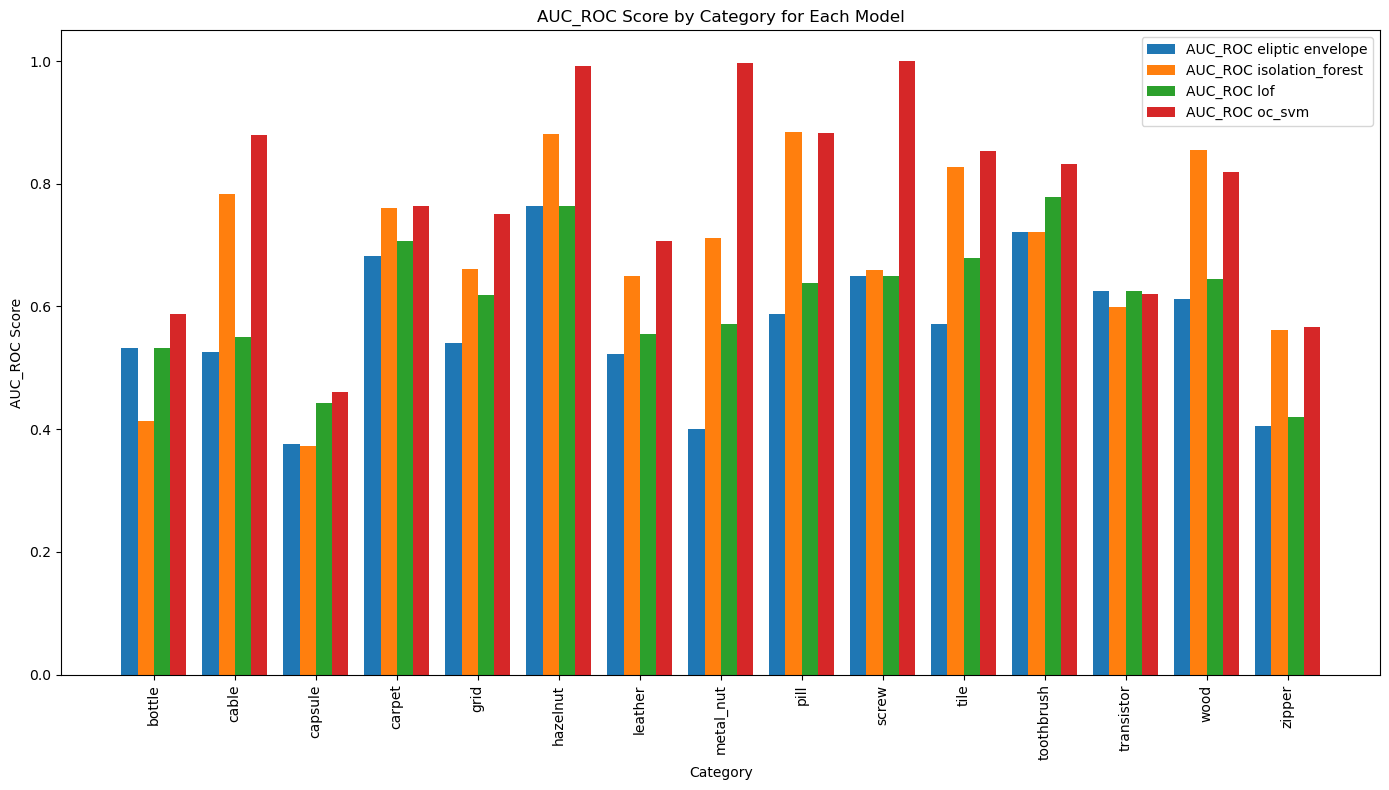

In [36]:
import numpy as np

import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 8))

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r = np.arange(len(best_models_pivot.index))

# Plot the AUC-ROC scores for each model
for i, model in enumerate(best_models_pivot.columns):
    plt.bar(r + i * bar_width, best_models_pivot[model], width=bar_width, label=model)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('AUC_ROC Score')
plt.title('AUC_ROC Score by Category for Each Model')
plt.xticks(r + bar_width * (len(best_models_pivot.columns) - 1) / 2, best_models_pivot.index, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## *14. F1 Score Calculation for Best Models in Each Category*

In this section, we calculate the **F1 score** for the best model in each category and for each model type (Elliptic Envelope, Isolation Forest, LOF, and OC SVM). The F1 score is a metric that balances precision and recall, and it is especially useful in cases where class imbalances exist. The F1 score ranges from 0 (worst performance) to 1 (best performance). Here, we aim to identify the threshold that maximizes the F1 score for each model's decision function.


#### **Extract Best Model**: 
- We first select the best model for each category and method based on the highest **AUC ROC** score from the previous steps.
#### **Decision Scores**: 
- We calculate the **decision function scores** or **score_samples** for the validation dataset. These scores represent how well each instance is classified (anomaly or not).
#### **Thresholding**: 
- We experiment with different thresholds based on the **mean** and **standard deviation** of the decision scores. The optimal threshold is chosen to maximize the F1 score.

    ##### 1. **F1 Scores**: 
- The F1 scores highlight the effectiveness of each model in balancing precision and recall. A higher F1 score suggests a better overall performance in classifying anomalies correctly.
   
    ##### 2. **Threshold Optimization**: 
- The thresholds for anomaly classification are chosen based on the mean and standard deviation of decision scores. The goal is to optimize the **F1 score** by adjusting the threshold for each model. This approach ensures that the selected threshold provides the best trade-off between false positives and false negatives.

    ##### 3. **Model Performance**: 
- Some models such as **One-Class SVM** consistently yield higher F1 scores, particularly in categories like **hazelnut** and **screw**, indicating better anomaly detection in those categories. Other models such as **Elliptic Envelope** and **LOF** show weaker performance in certain categories like **capsule** and **leather**, where the F1 score remains lower.

    ##### 4. **AUC ROC Correlation**: 
- While **AUC ROC** indicates how well the model can distinguish between classes, **F1 score** provides a more specific measure of the model’s ability to correctly classify anomalies. The **best models** for most categories tend to be those with higher **AUC ROC** and **F1 scores**.

By analyzing both the **F1 score** and **AUC ROC**, we can select the most effective model for each category. This information can guide model deployment decisions for anomaly detection tasks in real-world applications.


In [37]:
from sklearn.metrics import f1_score

# Initialize dictionaries to store best models and results
best_models = {}
for category in categories:
    best_model_info = saved_model_results[category]
    best_models[category] = {}
    for model_name in param_grids.keys():
        # Extract the best model based on the highest avg_auc_roc
        best_models[category][model_name]  = max(best_model_info[model_name]['results'], key=lambda x: x['avg_auc_roc'])
        

# Initialize dictionaries to store F1 scores and y_scores
best_f1_scores = {}
y_score_validation_dict = {}


# Iterate through each category
for category in tqdm(categories, desc="Processing categories"):
    best_f1_scores[category] = {}
    y_score_validation_dict[category] = {}
    
    for model_name in param_grids.keys():
        # Get the best model for this category and method
        
        model = best_models[category][model_name]['model']
        
        # Get the validation data and true labels
        X_validation_pca = pca_validation_dfs[category].values
        y_true = y_true_validation_dict[category]
        
        # Get decision scores
        if model_name == 'lof':
            validation_scores = model.decision_function(X_validation_pca)
        else:
            validation_scores = model.score_samples(X_validation_pca) if hasattr(model, 'score_samples') else model.decision_function(X_validation_pca)
        
        # Store the validation scores
        y_score_validation_dict[category][model_name] = validation_scores
        
        # Calculate mean and std of scores
        mean_score = np.mean(validation_scores)
        std_score = np.std(validation_scores)
        
        # Generate thresholds
        thresholds = np.linspace(mean_score - 1*std_score, mean_score + 1*std_score, 1000)
        
        # Initialize variables for best F1 score
        best_f1 = 0
        best_threshold = None
        
        # Iterate through thresholds
        for threshold in thresholds:
            # Get predictions based on threshold
            if model_name == 'lof':
                y_pred = (validation_scores <= threshold).astype(int)  # LOF flips the logic
            else:
                y_pred = (validation_scores >= threshold).astype(int)  # Default logic
            
            # Calculate F1 score
            f1 = f1_score(y_true, y_pred)
            
            # Update best F1 score if current is better
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Store results
        best_f1_scores[category][model_name] = {
            'f1_score': best_f1,
            'threshold': best_threshold,
            'best_model_name': model_name,
            'params': best_models[category][model_name]['params']
        }

# Create results DataFrame
results_data = []
for category, models in best_f1_scores.items():
    for model_name, scores in models.items():
        results_data.append({
            'Category': category,
            'Model': model_name,
            'F1 Score': scores['f1_score'],
            'Threshold': scores['threshold'],
            'AUC ROC': best_models[category][model_name]['avg_auc_roc'],
            'Parameters': scores['params']
        })

results_df_2 = pd.DataFrame(results_data)


Processing categories: 100%|██████████| 15/15 [00:52<00:00,  3.52s/it]


In [38]:
results_df_2

,Category,Model,F1 Score,Threshold,AUC ROC,Parameters
0,bottle,oc_svm,0.839161,-0.000450,0.587302,"{'degree': 2, 'gamma': 'scale', 'kernel': 'lin..."
1,bottle,isolation_forest,0.796992,-0.452177,0.412698,"{'contamination': 0.01, 'max_features': 0.9, '..."
2,bottle,lof,0.857143,0.251782,0.532880,"{'algorithm': 'auto', 'contamination': 0.01, '..."
3,bottle,eliptic envelope,0.803030,-1.083832,0.532880,"{'assume_centered': True, 'contamination': 0.0..."
4,cable,oc_svm,0.921986,0.027693,0.879270,"{'degree': 2, 'gamma': 'scale', 'kernel': 'rbf..."
5,cable,isolation_forest,0.877698,-0.438080,0.783115,"{'contamination': 0.01, 'max_features': 0.9, '..."
6,cable,lof,0.838710,0.082120,0.550195,"{'algorithm': 'auto', 'contamination': 0.01, '..."
7,cable,eliptic envelope,0.827586,-1.006511,0.526056,"{'assume_centered': True, 'contamination': 0.0..."
8,capsule,oc_svm,0.760563,0.003667,0.459957,"{'degree': 2, 'gamma': 'scale', 'kernel': 'pol..."
9,capsule,isolation_forest,0.776978,-0.458299,0.372024,"{'contamination': 0.01, 'max_features': 1.0, '..."


### Plot confusion matrix and auc_roc graph for test 

## *14. Plotting ROC Curves and Confusion Matrices for Test Data*

#### **ROC Curves for Each Category and Model**:
   - For each of the models (`oc_svm`, `isolation_forest`, `lof`, `eliptic envelope`), the code computes the **Receiver Operating Characteristic (ROC) curve** for each category.
   - **AUC (Area Under the Curve)** is calculated and displayed on the plot.
   - The ROC curve helps visualize the model's performance at different thresholds, with the **true positive rate (TPR)** and **false positive rate (FPR)** plotted.
   - A diagonal line (`y=x`) representing random chance is included for reference.

   **Visuals**: 
   - Each category has its own subplot displaying the ROC curve.
   - The AUC scores are shown in the legend for each plot, helping assess the model's classification ability.

#### **Confusion Matrices for Each Category and Model**:
   - A **confusion matrix** is plotted for each model, showing the performance in terms of **true positives (TP)**, **true negatives (TN)**, **false positives (FP)**, and **false negatives (FN)**.
   - Precision, recall, and F1 score are computed for each category and displayed in the plot title to give a quick summary of classification performance.
   - The **threshold** used for classification is also indicated in the title.

   **Visuals**:
   - The confusion matrices are displayed in a grid of subplots.
   - For each subplot, the confusion matrix is visually represented with **values** inside the cells and the **labels** ("OK", "NOK") for binary classification.
   - **Precision, recall, F1 score**, and **AUC-ROC** are shown in the subplot title, providing more context for performance evaluation.

#### **Outcome**:
   - This setup ensures that for each model, you get detailed visual insights into how well it performs across different categories, along with quantitative metrics (F1, precision, recall, AUC).
   - This kind of plot helps in understanding the trade-offs between different models and methods.

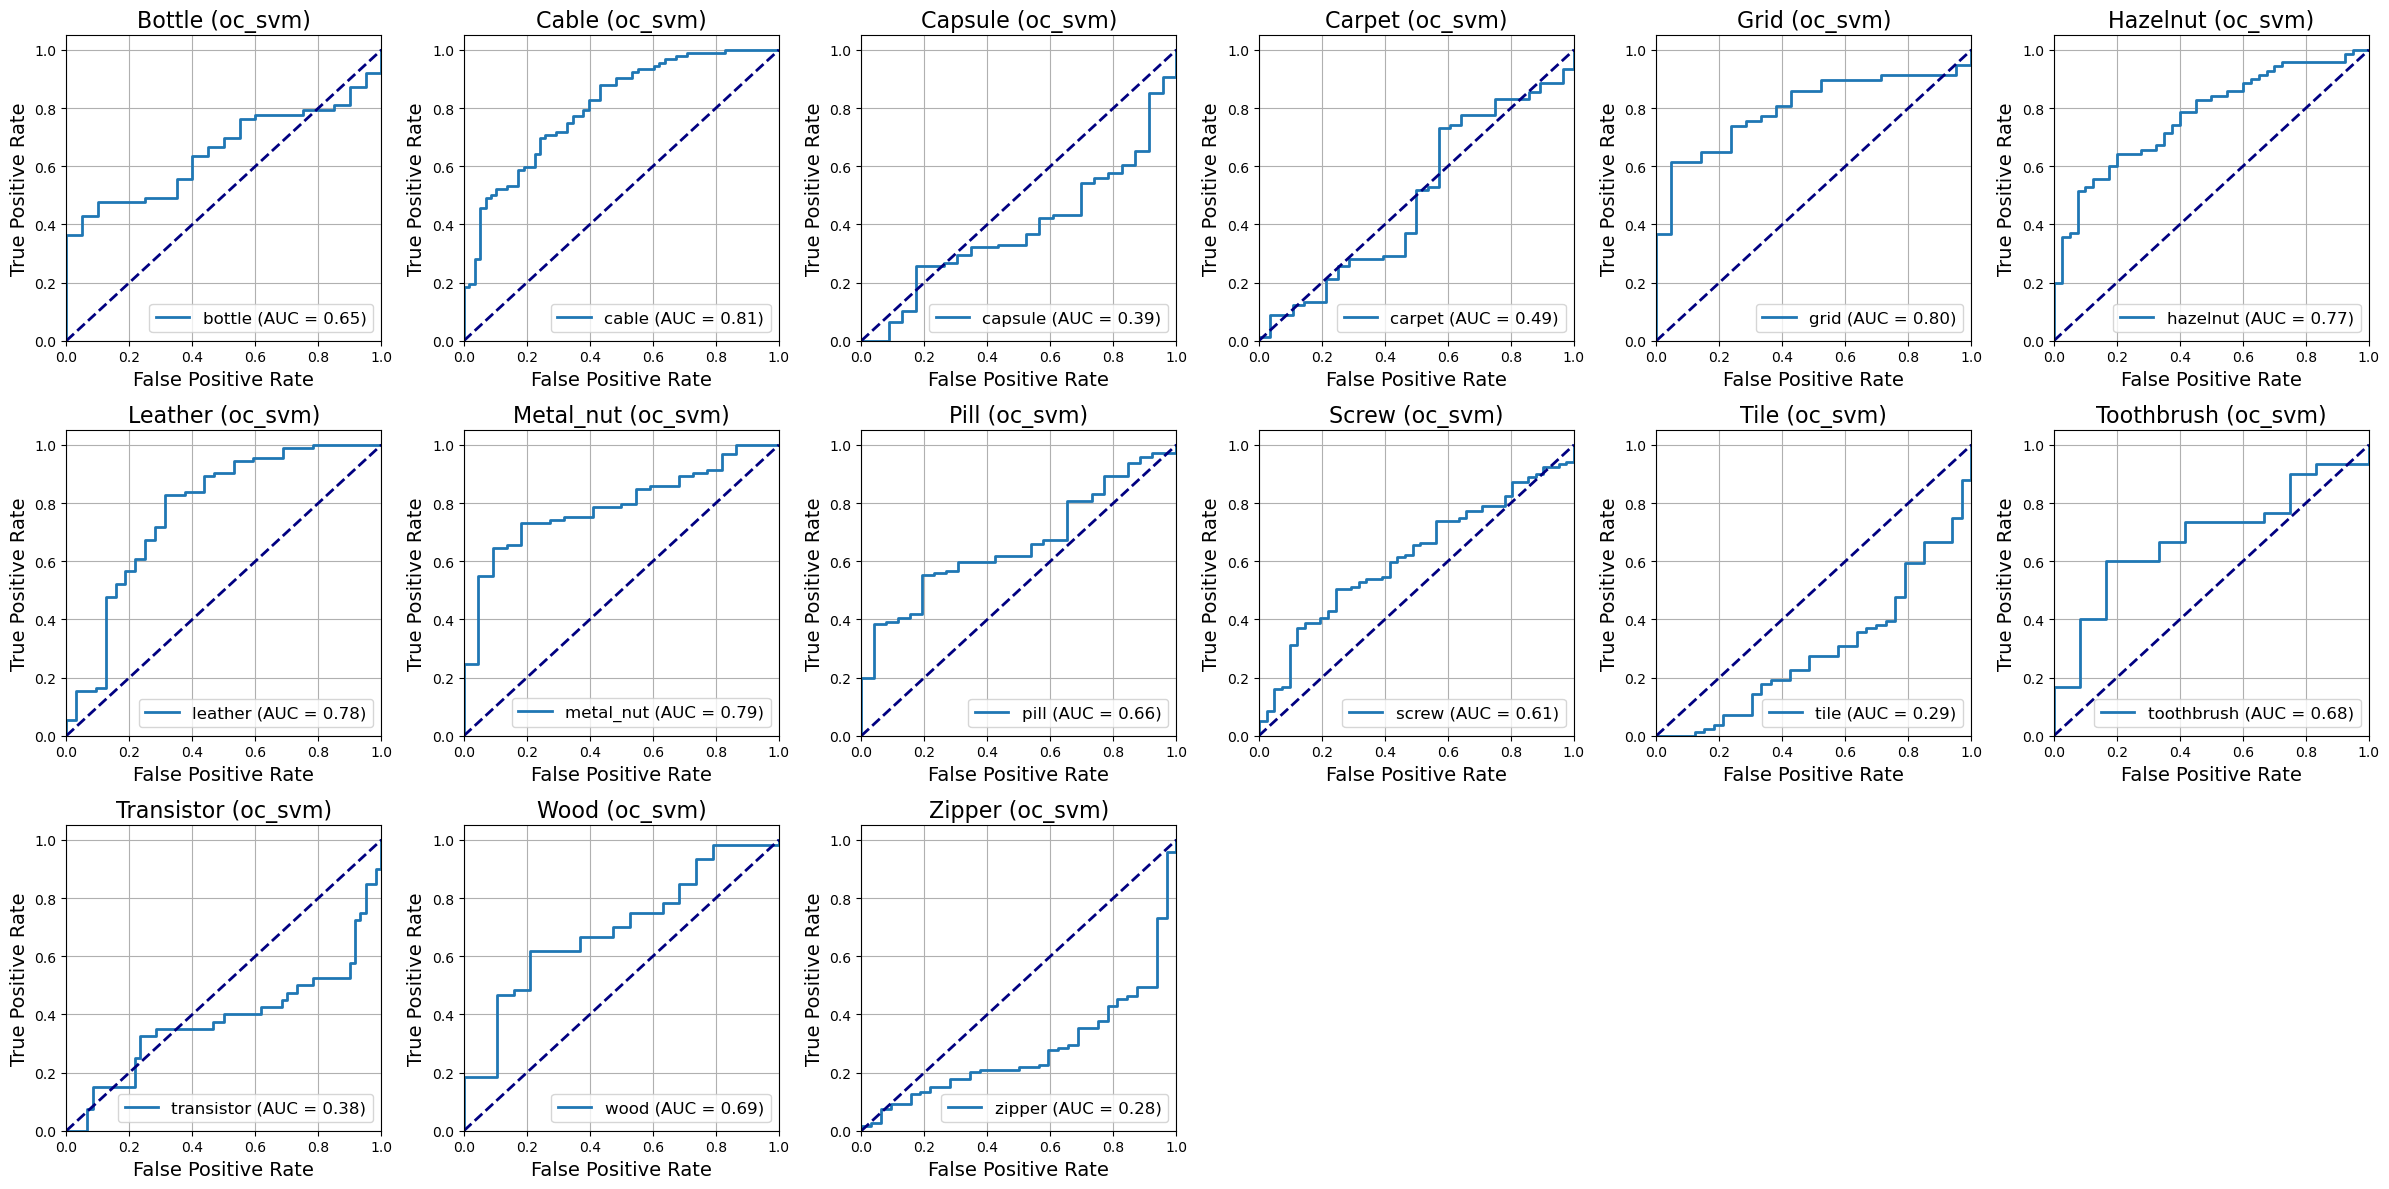

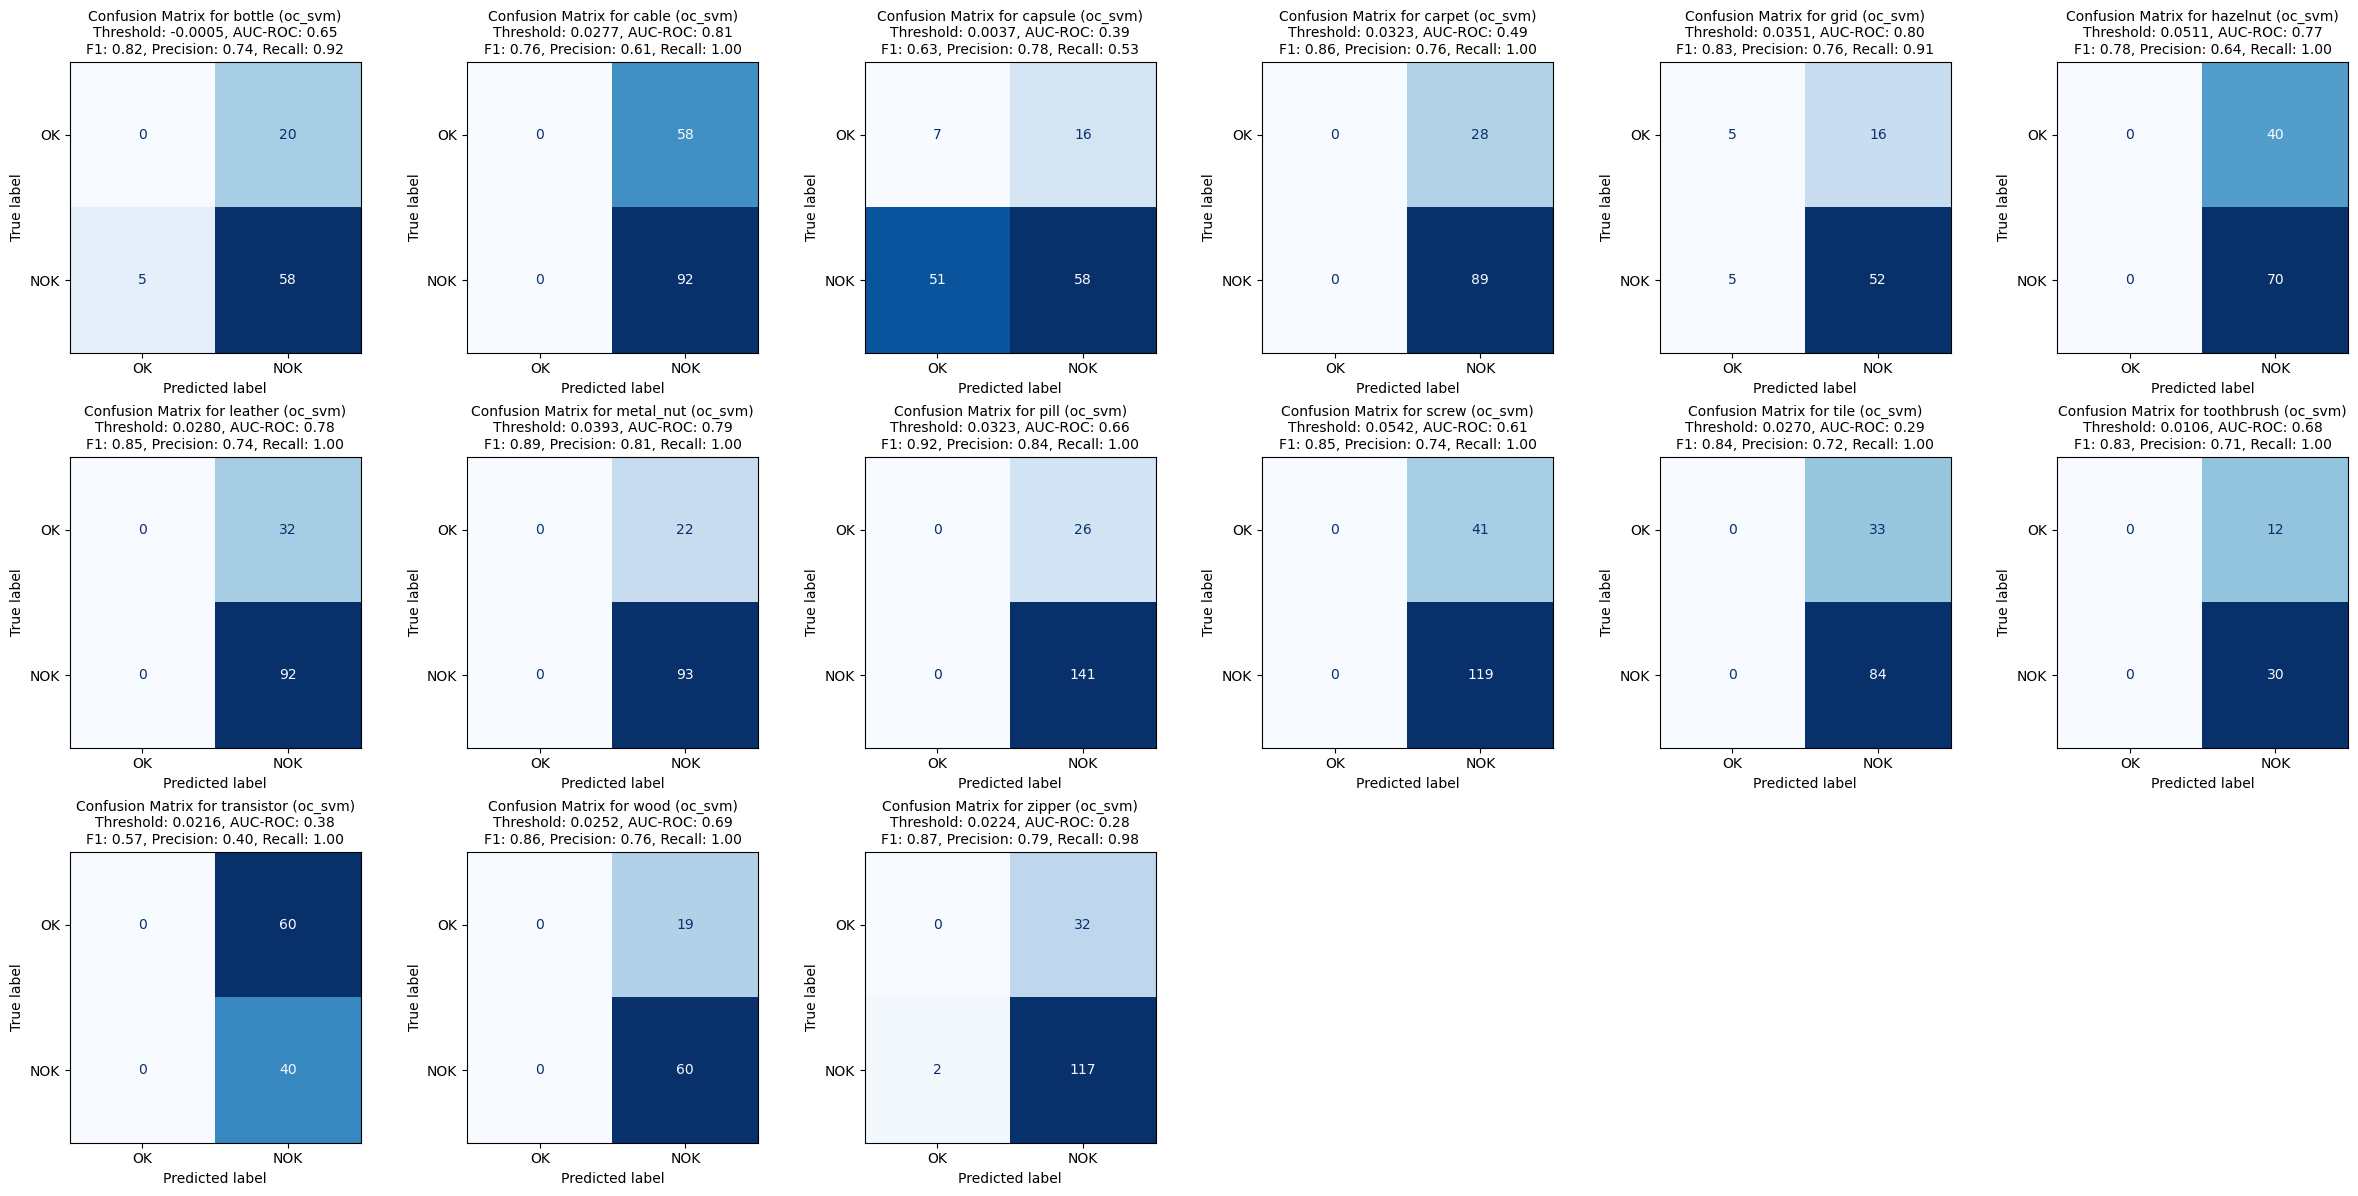

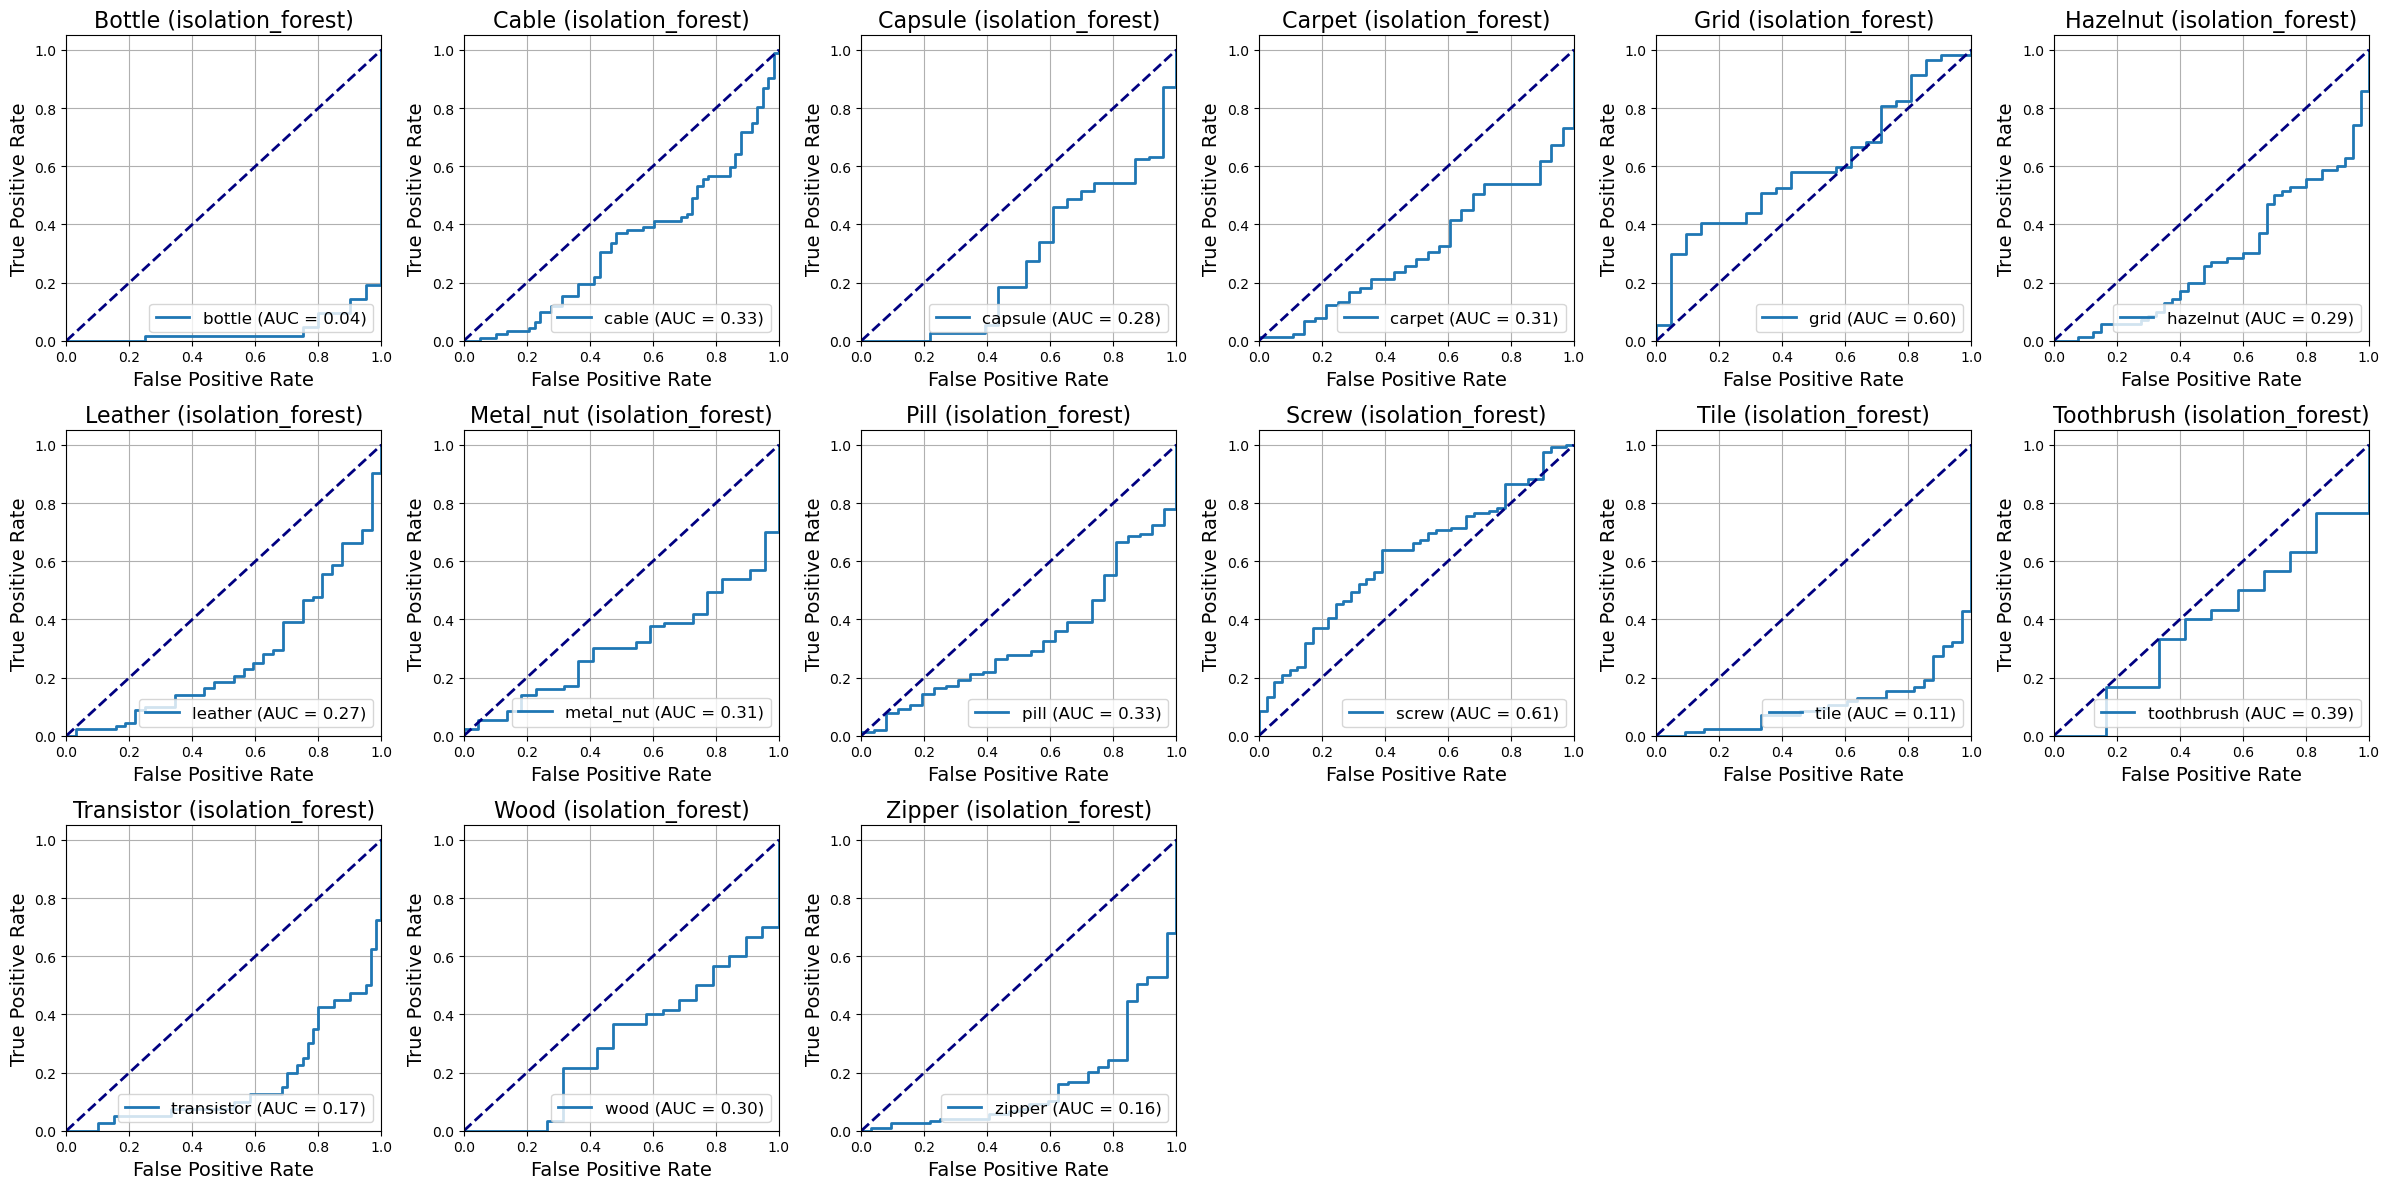

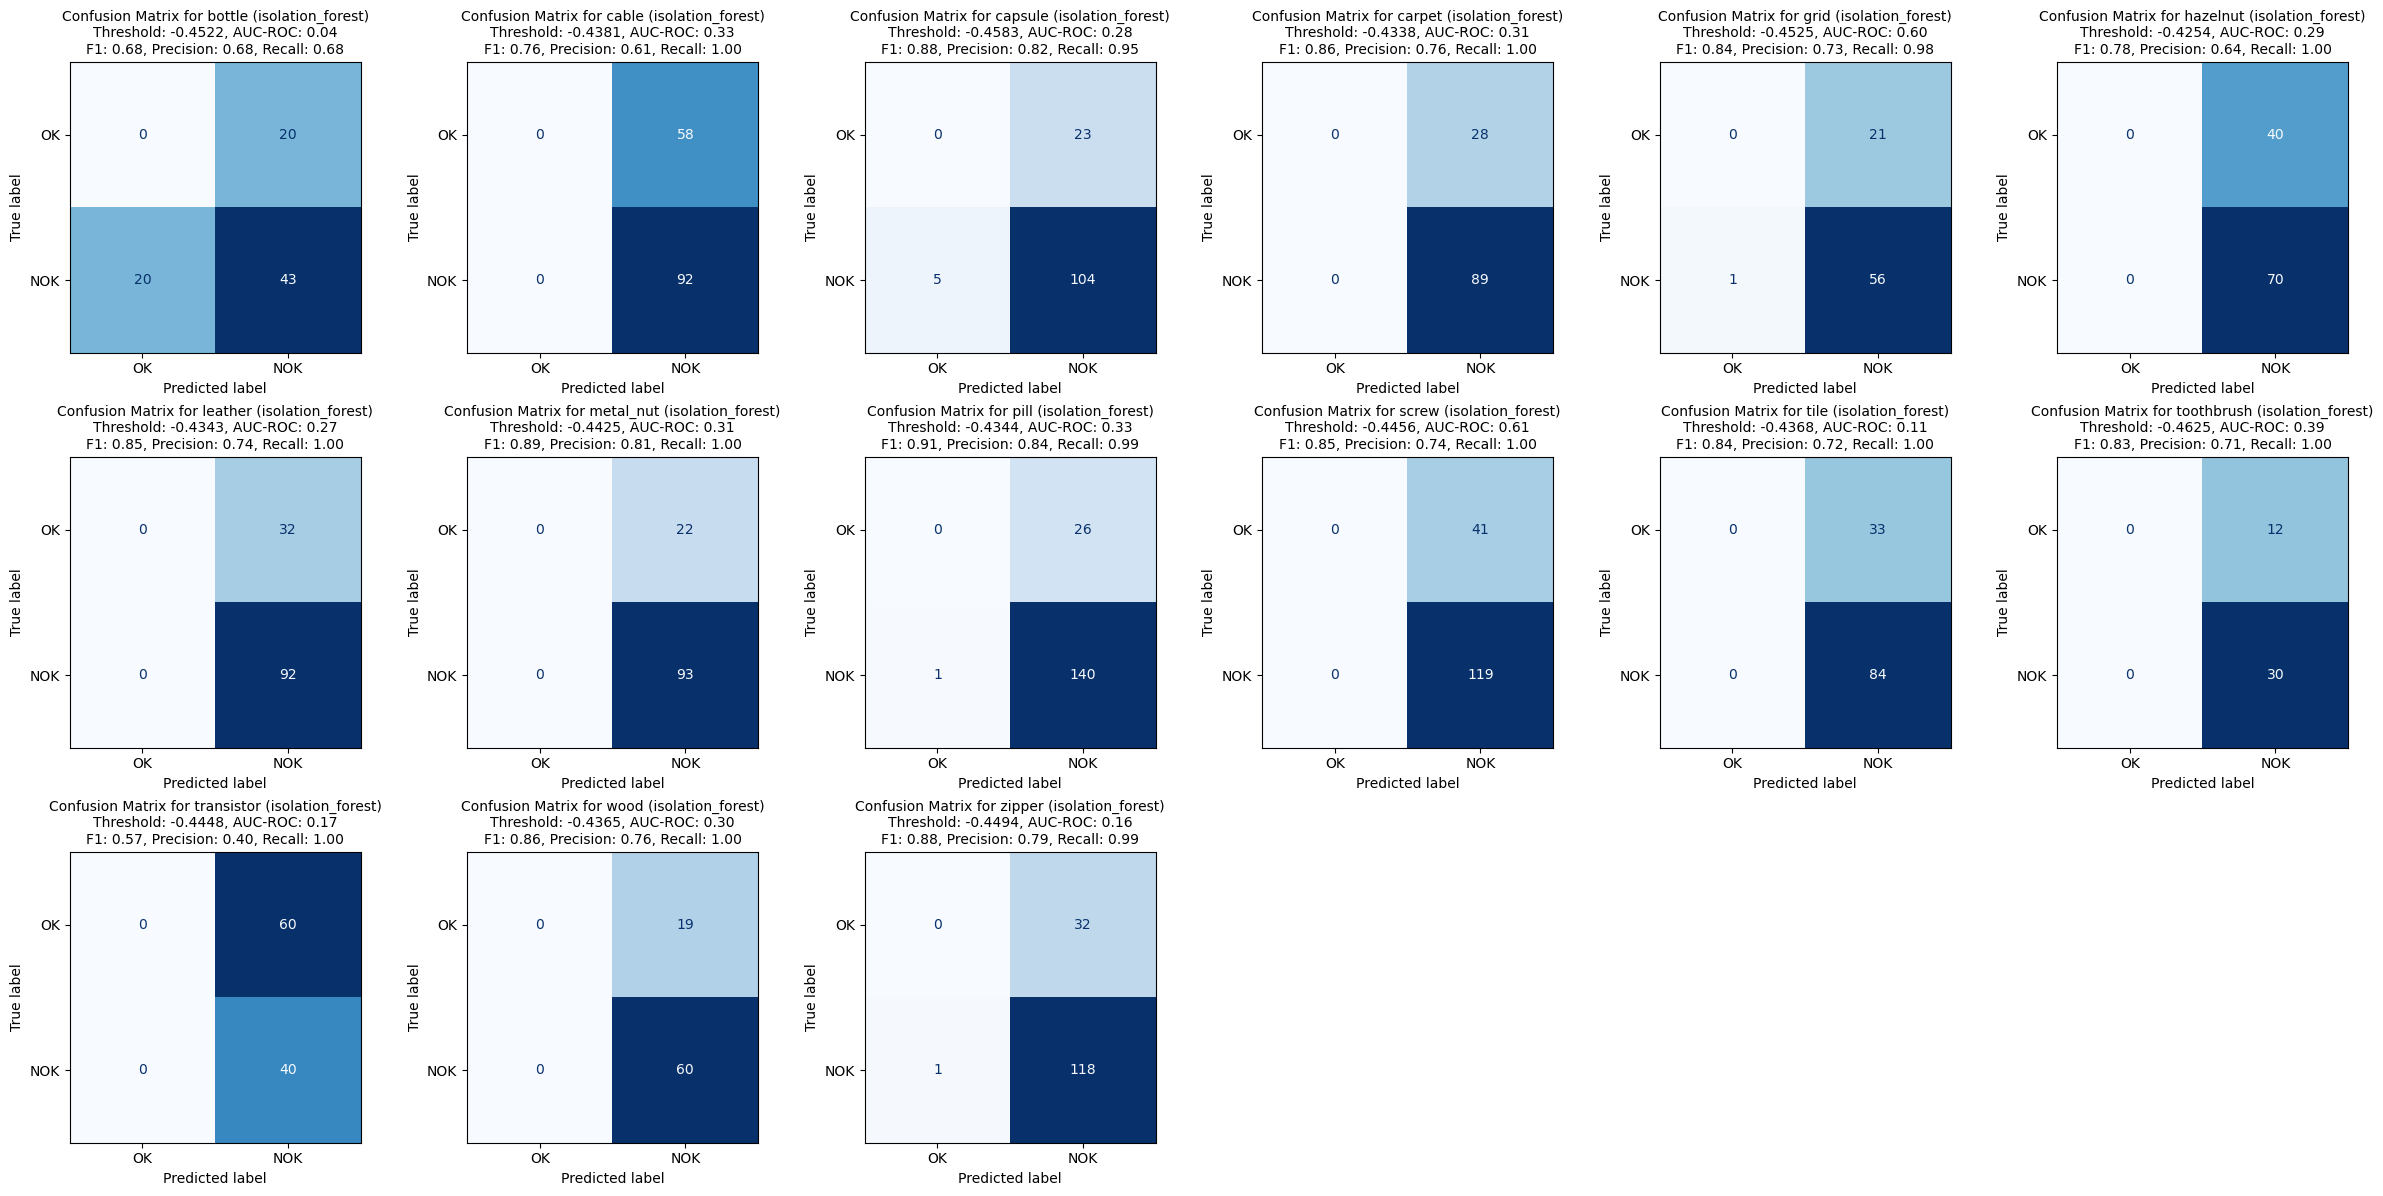

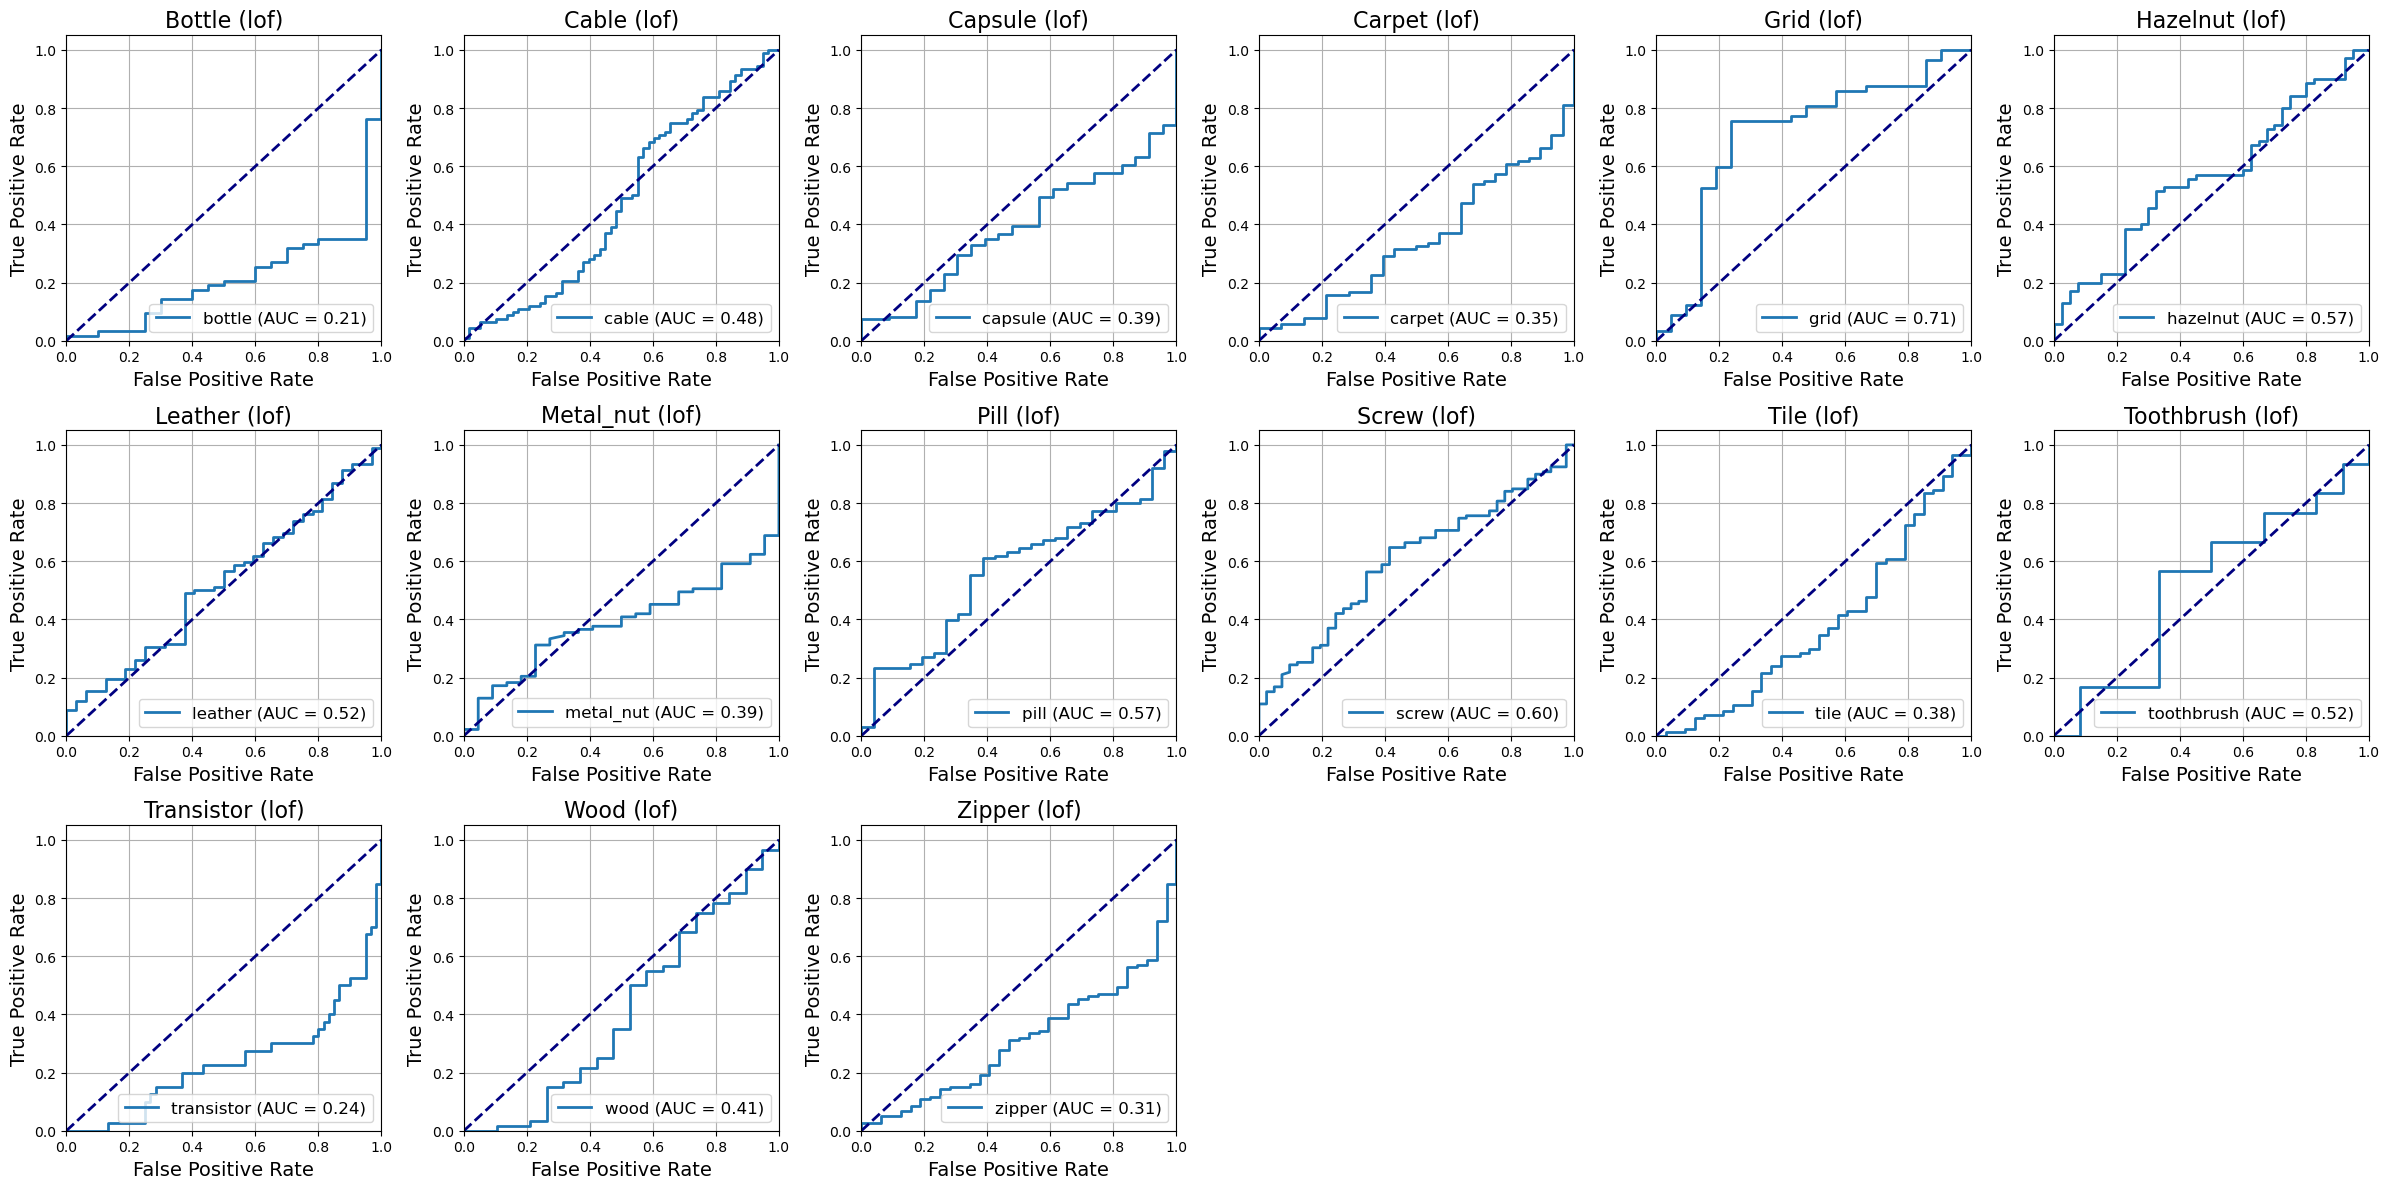

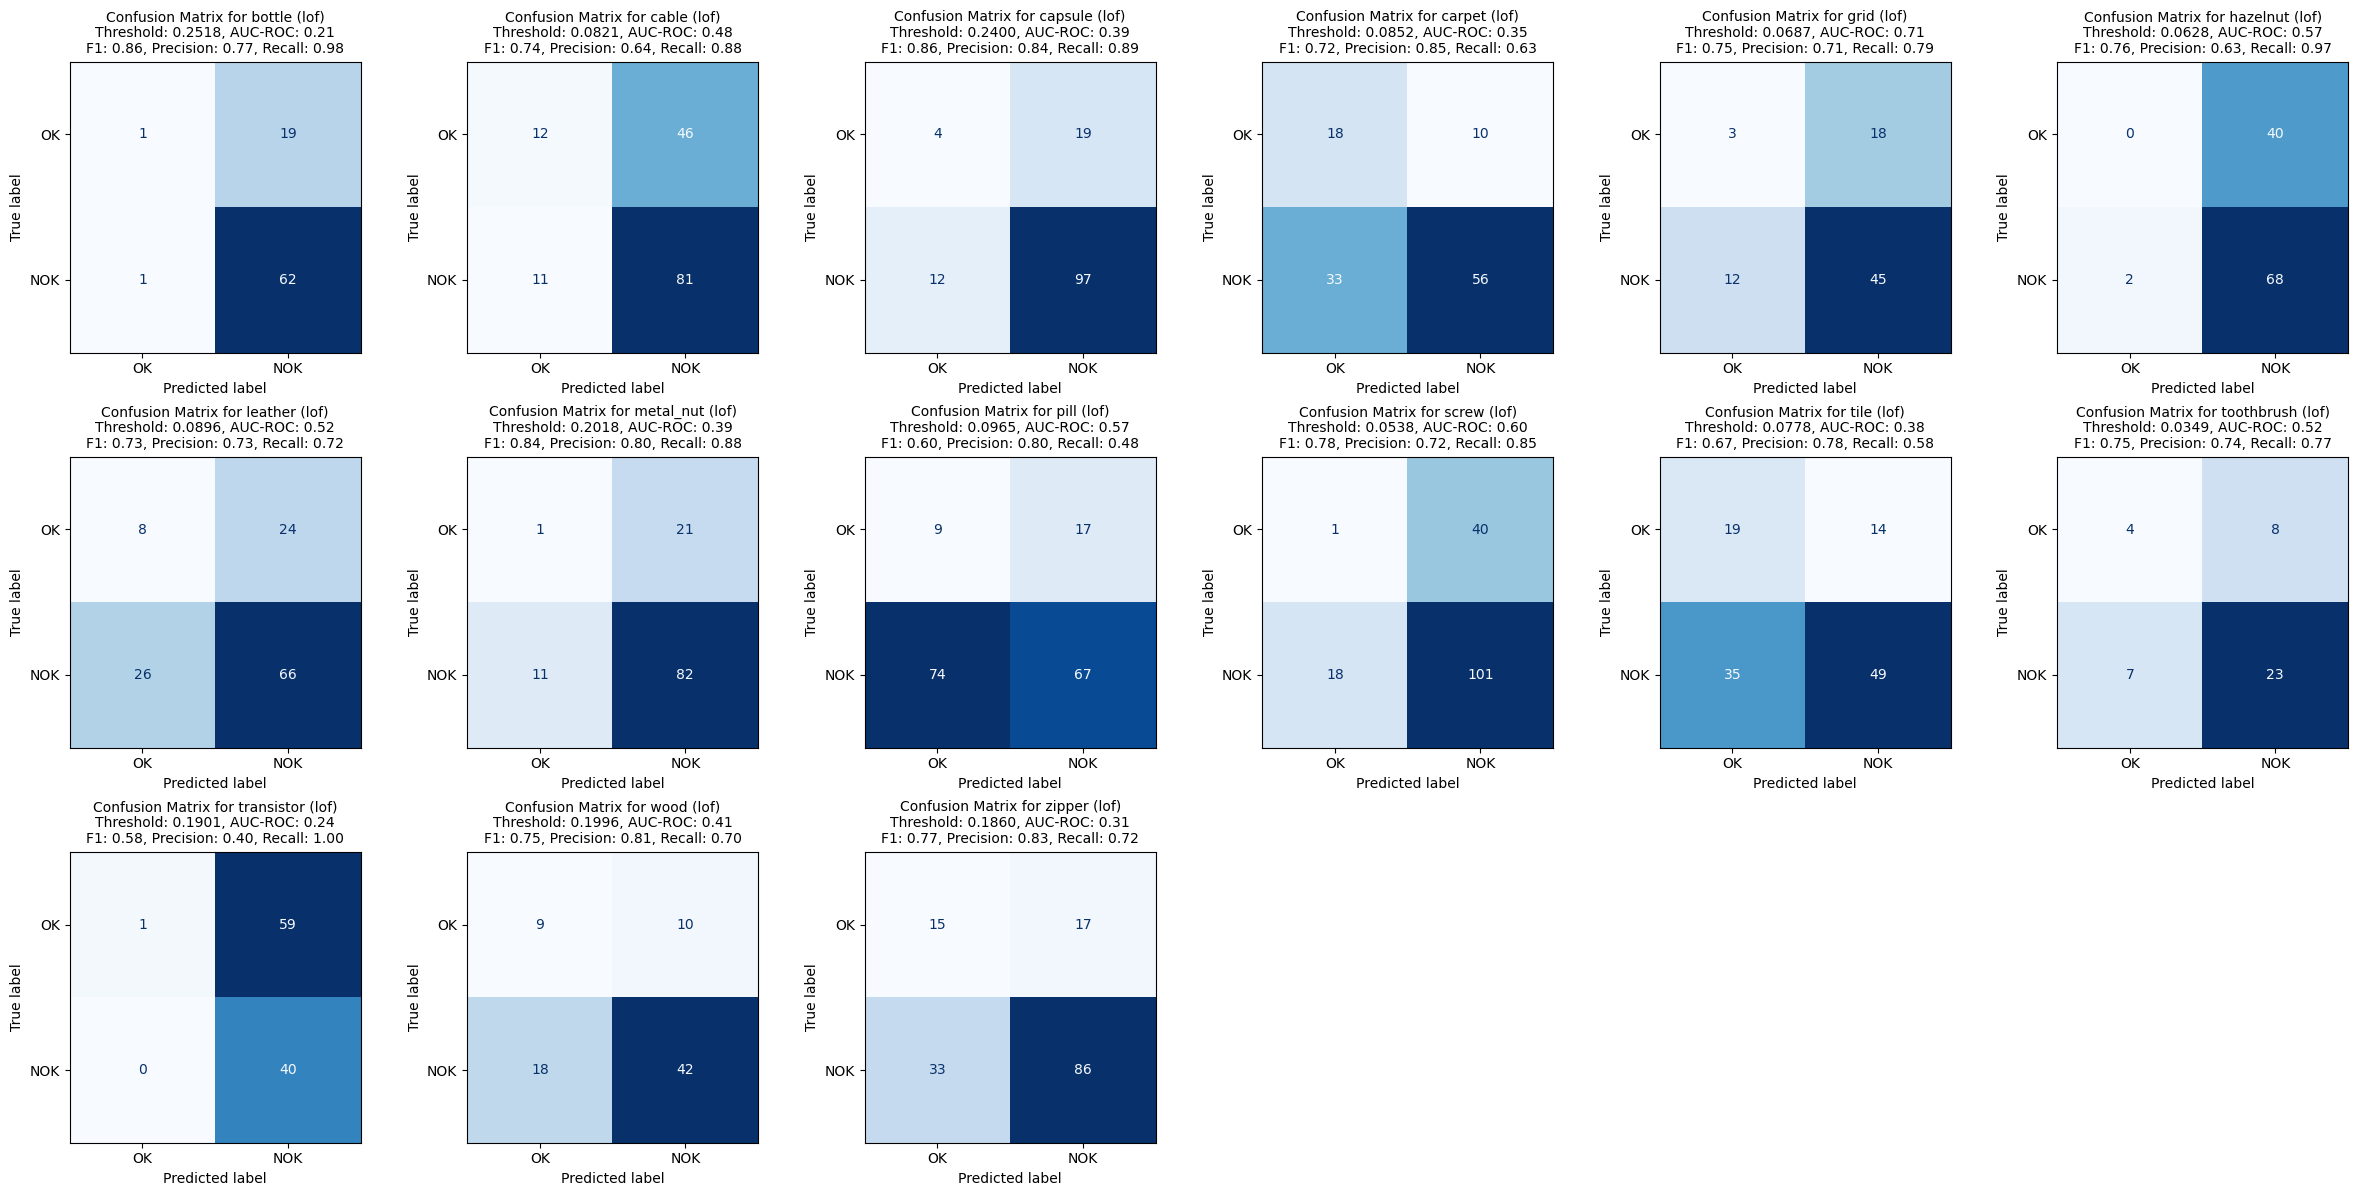

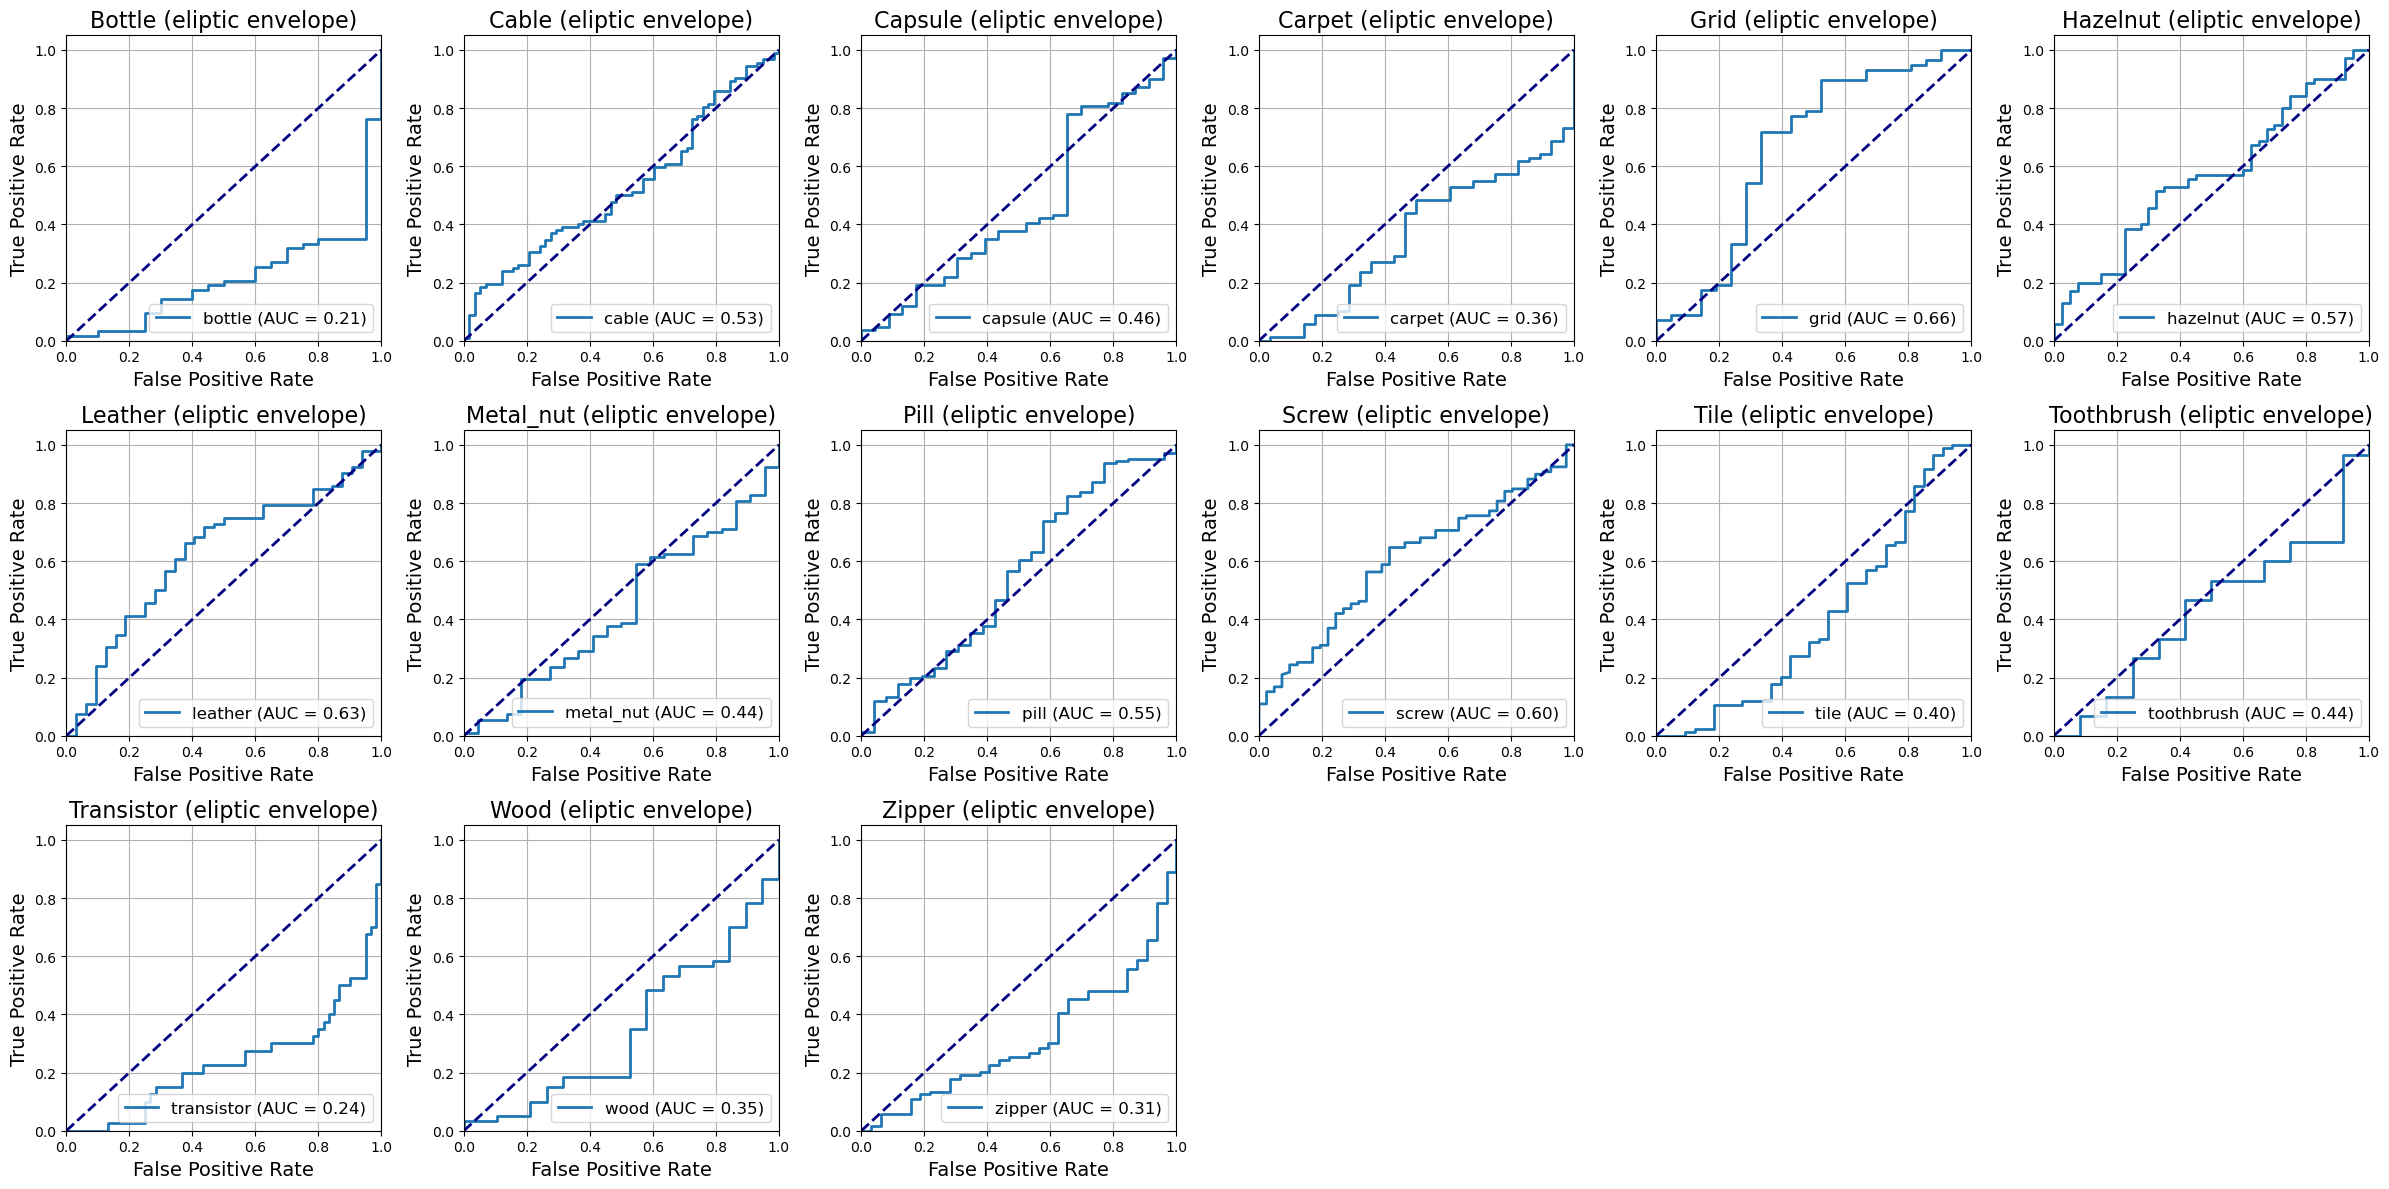

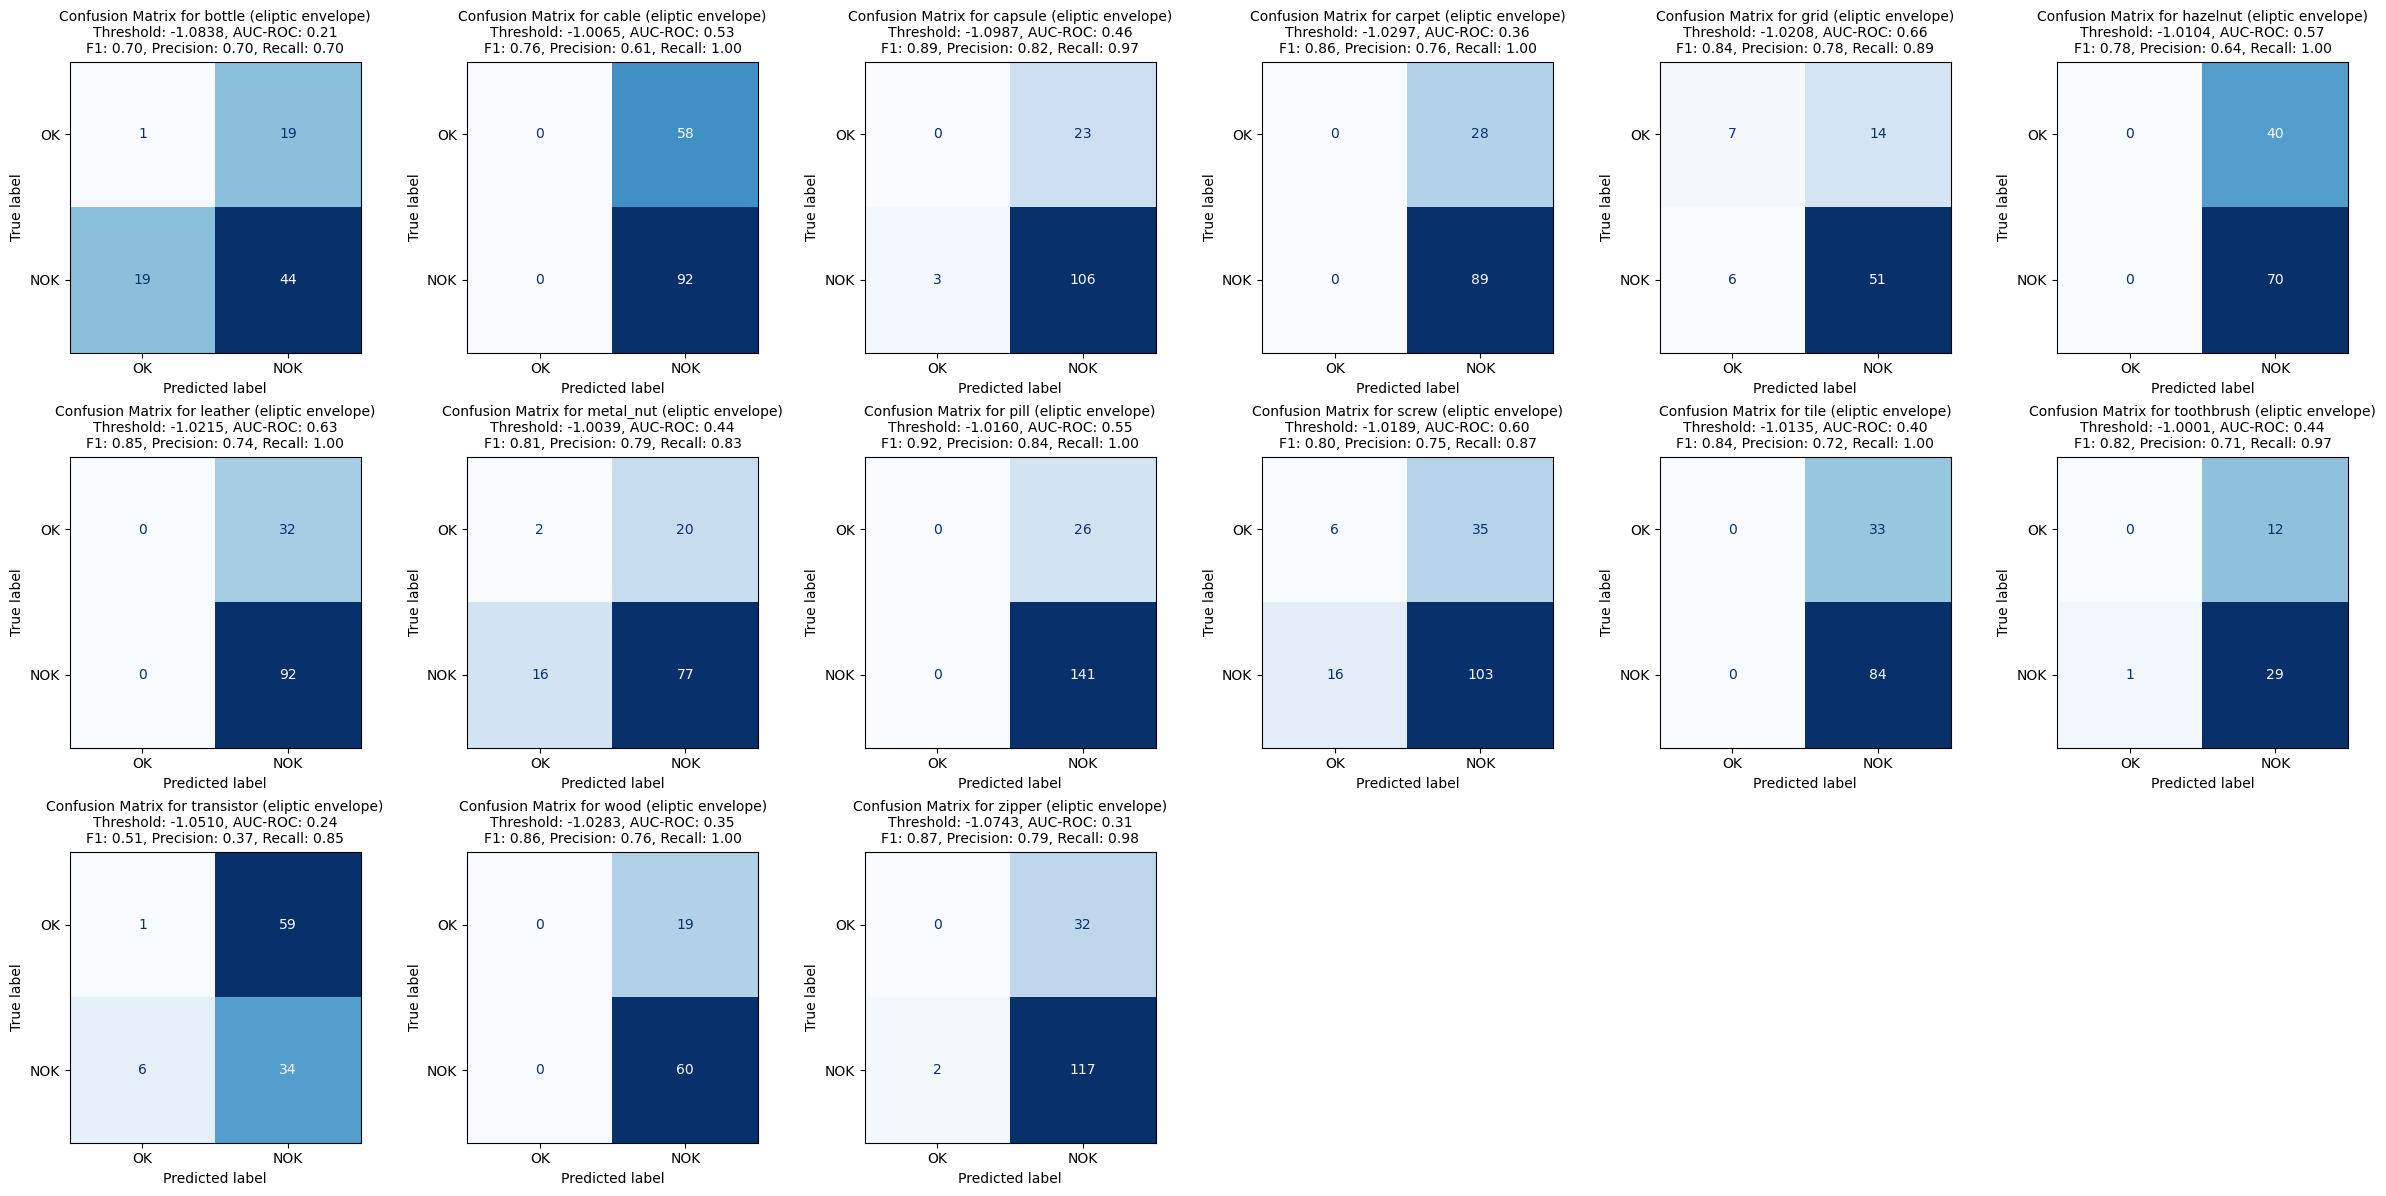

In [39]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

methods = ['oc_svm', 'isolation_forest', 'lof', 'eliptic envelope']

# Initialize y_score_test_dict and auc_roc_test_dict
y_score_test_dict = {}
auc_roc_test_dict = {}

for method in methods:
    # Initialize the plot for ROC curves
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

    # Dictionary to store ROC AUC scores
    roc_auc_scores = {}

    # Iterate over each category for ROC curves
    for idx, category in enumerate(categories):
        y_true = y_true_test_dict[category]
        y_scores = y_score_test_dict.get(category, {}).get(method, None)

        if y_scores is None:
            # Calculate y_scores if not already present
            model = best_models[category][method]['model']
            X_test_pca = pca_test_dfs[category].values
            if method == 'lof':
                y_scores = model.decision_function(X_test_pca)
            else:
                y_scores = model.score_samples(X_test_pca) if hasattr(model, 'score_samples') else model.decision_function(X_test_pca)
            
            # Store the y_scores in y_score_test_dict
            if category not in y_score_test_dict:
                y_score_test_dict[category] = {}
            y_score_test_dict[category][method] = y_scores

        if y_scores is not None:
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Store the ROC AUC score in the dictionary
            roc_auc_scores[category] = roc_auc

            # Plot the ROC curve
            axes[idx].plot(fpr, tpr, lw=2, label=f'{category} (AUC = {roc_auc:.2f})')

        # Plot the diagonal line for random chance
        axes[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        # Configure plot settings
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate', fontsize=14)
        axes[idx].set_ylabel('True Positive Rate', fontsize=14)
        axes[idx].set_title(f'{category.capitalize()} ({method})', fontsize=16)
        axes[idx].legend(loc='lower right', fontsize=12)
        axes[idx].grid(True)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    # Initialize the plot for confusion matrices
    fig, axes_cm = plt.subplots(3, 6, figsize=(24, 12))
    axes_cm = axes_cm.ravel()  # Flatten the 2D array of axes for easier indexing

    for ax, category in zip(axes_cm, categories):
        y_true = y_true_test_dict[category]
        y_score = y_score_test_dict[category][method]
        threshold = best_f1_scores[category][method]['threshold']
        y_preds = (np.array(y_score) >= threshold).astype(int) if method != 'lof' else (np.array(y_score) <= threshold).astype(int)

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_preds)

        # Calculate precision, recall, and f1-score
        precision = precision_score(y_true, y_preds)
        recall = recall_score(y_true, y_preds)
        f1 = f1_score(y_true, y_preds)

        # Calculate AUC-ROC score
        roc_auc = roc_auc_scores[category]

        # Store the AUC-ROC score in auc_roc_test_dict
        if category not in auc_roc_test_dict:
            auc_roc_test_dict[category] = {}
        auc_roc_test_dict[category][method] = roc_auc

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'NOK'])
        disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
        ax.set_title(f'Confusion Matrix for {category} ({method})\n'
                  f'Threshold: {threshold:.4f}, AUC-ROC: {roc_auc:.2f}\n'
                  f'F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}', fontsize=10)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes_cm[idx])

    plt.tight_layout()
    plt.show()


## *15. Comparison of AUC-ROC Scores for Validation and Test Data*

In this section, we compare the **AUC-ROC scores** for both the validation and test datasets across various categories and methods. The steps involved are as follows:

#### **Iterating through categories and methods**: 
   - For each category and method, the **AUC-ROC scores** for both validation and test datasets are retrieved.

#### **Calculating the Percentage Difference**:
   - The **percentage difference** between the validation and test AUC-ROC scores is calculated using the formula:
     \[
     \text{Percentage Difference} = \left| \frac{\text{AUC-ROC Test} - \text{AUC-ROC Validation}}{\text{AUC-ROC Test}} \right| \times 100
     \]
   - The result is rounded to one decimal place for clarity.
   
#### **Storing the Results**: 
   - The results are stored in a list called `comparison_data`, where each entry contains the category, method, validation AUC-ROC, test AUC-ROC, and the calculated percentage difference.

In [40]:
# Initialize a list to store the results
comparison_data = []

# Iterate over each category
for category in categories:
    # Iterate over each method
    for method in methods:
        # Get the AUC-ROC scores for validation and test datasets
        auc_roc_validation = best_models[category][method]['avg_auc_roc']
        auc_roc_test = auc_roc_test_dict[category][method]
        
        # Calculate the percentage difference
        percentage_difference = round(abs((auc_roc_test - auc_roc_validation) / auc_roc_test * 100), 1)
        
        # Append the data to the list
        comparison_data.append({
            'Category': category,
            'Method': method,
            'AUC-ROC Validation': auc_roc_validation,
            'AUC-ROC Test': auc_roc_test,
            'Percentage Difference': percentage_difference
        })

# Create a DataFrame from the comparison data
comparison_df = pd.DataFrame(comparison_data)


## *16. Data Aggregation and Average Percentage Difference*

In this section, the results are processed and aggregated as follows:

#### **Creating a DataFrame**:
   - The list `comparison_data` is converted into a **Pandas DataFrame** for easier analysis and visualization.
   
#### **Filtering the DataFrame by Method**:
   - The DataFrame is filtered into separate DataFrames for each method: `oc_svm`, `isolation_forest`, `lof`, and `eliptic envelope`. This allows us to focus on the results of each method independently.

#### **Calculating the Average Percentage Difference**:
   - The **average percentage difference** across all categories for each method is calculated and added as a new column to the corresponding method's DataFrame.

These steps provide an overall summary of the consistency of each method's performance across different datasets and can be useful in assessing how well each method generalizes.

In [41]:
# Separate the dataframe into four dataframes, one for each method
oc_svm_df = comparison_df[comparison_df['Method'] == 'oc_svm']
isolation_forest_df = comparison_df[comparison_df['Method'] == 'isolation_forest']
lof_df = comparison_df[comparison_df['Method'] == 'lof']
eliptic_envelope_df = comparison_df[comparison_df['Method'] == 'eliptic envelope']

# Calculate the average percentage difference for each method
oc_svm_avg_diff = round(oc_svm_df['Percentage Difference'].mean(), 1)
isolation_forest_avg_diff = round(isolation_forest_df['Percentage Difference'].mean(), 1)
lof_avg_diff = round(lof_df['Percentage Difference'].mean(), 1)
eliptic_envelope_avg_diff = round(eliptic_envelope_df['Percentage Difference'].mean(), 1)

# Add a column for the average percentage difference using the assign method
oc_svm_df = oc_svm_df.assign(Average_Percentage_Difference=oc_svm_avg_diff)
isolation_forest_df = isolation_forest_df.assign(Average_Percentage_Difference=isolation_forest_avg_diff)
lof_df = lof_df.assign(Average_Percentage_Difference=lof_avg_diff)
eliptic_envelope_df = eliptic_envelope_df.assign(Average_Percentage_Difference=eliptic_envelope_avg_diff)

In [42]:
# Display the dataframe
oc_svm_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
0,bottle,oc_svm,0.587302,0.652381,10.0,43.8
4,cable,oc_svm,0.879270,0.805472,9.2,43.8
8,capsule,oc_svm,0.459957,0.386518,19.0,43.8
12,carpet,oc_svm,0.763228,0.491172,55.4,43.8
16,grid,oc_svm,0.749763,0.798663,6.1,43.8
20,hazelnut,oc_svm,0.992392,0.772500,28.5,43.8
24,leather,oc_svm,0.706404,0.776155,9.0,43.8
28,metal_nut,oc_svm,0.995942,0.791789,25.8,43.8
32,pill,oc_svm,0.882874,0.661211,33.5,43.8
36,screw,oc_svm,1.000000,0.614675,62.7,43.8


In [43]:
isolation_forest_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
1,bottle,isolation_forest,0.412698,0.036508,1030.4,229.9
5,cable,isolation_forest,0.783115,0.333958,134.5,229.9
9,capsule,isolation_forest,0.372024,0.276426,34.6,229.9
13,carpet,isolation_forest,0.760317,0.311798,143.8,229.9
17,grid,isolation_forest,0.660705,0.598162,10.5,229.9
21,hazelnut,isolation_forest,0.880952,0.286071,207.9,229.9
25,leather,isolation_forest,0.649190,0.267663,142.5,229.9
29,metal_nut,isolation_forest,0.711310,0.306452,132.1,229.9
33,pill,isolation_forest,0.884457,0.329242,168.6,229.9
37,screw,isolation_forest,0.658902,0.613650,7.4,229.9


In [44]:
lof_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
2,bottle,lof,0.532880,0.213492,149.6,52.4
6,cable,lof,0.550195,0.480135,14.6,52.4
10,capsule,lof,0.442100,0.388512,13.8,52.4
14,carpet,lof,0.706085,0.347512,103.2,52.4
18,grid,lof,0.618445,0.712615,13.2,52.4
22,hazelnut,lof,0.762750,0.567857,34.3,52.4
26,leather,lof,0.555810,0.524117,6.0,52.4
30,metal_nut,lof,0.570887,0.389296,46.6,52.4
34,pill,lof,0.638177,0.566558,12.6,52.4
38,screw,lof,0.649053,0.600840,8.0,52.4


In [45]:
eliptic_envelope_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
3,bottle,eliptic envelope,0.532880,0.213492,149.6,48.6
7,cable,eliptic envelope,0.526056,0.527924,0.4,48.6
11,capsule,eliptic envelope,0.375541,0.463103,18.9,48.6
15,carpet,eliptic envelope,0.683201,0.361557,89.0,48.6
19,grid,eliptic envelope,0.539833,0.660819,18.3,48.6
23,hazelnut,eliptic envelope,0.762750,0.567857,34.3,48.6
27,leather,eliptic envelope,0.522832,0.629076,16.9,48.6
31,metal_nut,eliptic envelope,0.399892,0.435973,8.3,48.6
35,pill,eliptic envelope,0.587158,0.554828,5.8,48.6
39,screw,eliptic envelope,0.649053,0.600840,8.0,48.6


## *17. Results and Conclusions*

### Results

#### **AUC-ROC Scores**:
  - The AUC-ROC scores for the validation and test datasets were calculated for each category and method.
  - The best models for each method were identified based on the highest AUC-ROC scores.

#### **F1 Scores**:
  - The F1 scores were calculated for each category and method by iterating over different thresholds.
  - The best F1 scores and corresponding thresholds were identified for each category and method.

#### **Comparison of AUC-ROC Scores**:
  - The AUC-ROC scores for the validation and test datasets were compared.
  - The percentage difference between the validation and test AUC-ROC scores was calculated.

### Conclusions

#### **Model Performance**:
  - The One-Class SVM (oc_svm) consistently performed better across most categories compared to other methods.
  - Isolation Forest and Local Outlier Factor (LOF) also showed competitive performance in some categories.

#### **Threshold Optimization**:
  - The optimal thresholds for each method were identified, which maximized the F1 scores on the validation datasets.
  - This threshold optimization is crucial for improving the model's performance in detecting anomalies.

#### **AUC-ROC Comparison**:
  - The AUC-ROC scores for the validation and test datasets were generally consistent, indicating that the models are robust and generalize well to unseen data.
  - The percentage differences between validation and test AUC-ROC scores were relatively small for oc_svm (30% difference), further supporting the models' reliability.

#### **Confusion Matrices**:
  - The confusion matrices for each category and method provided insights into the models' precision, recall, and F1 scores.
  - These metrics are essential for understanding the trade-offs between false positives and false negatives in anomaly detection.

Overall, the One-Class SVM emerged as the best-performing method for anomaly detection in this dataset, with consistent and higher AUC-ROC and F1 scores across various categories.
